## 스프린트 미션 #9
#### 3팀 전수현 
#### 제출일자: 25.07.17

이번 과제는 `FashionMNIST` 데이터셋을 활용하여 cGAN 모델을 개발해보는 것이다. 이 데이터셋은 이미 많은 연구가 이루어졌고 개인적으로 다뤄본 경험도 있기 때문에 EDA는 크게 하지 않아도 될것 같다. 다만 이번 데이터의 구성을 잠시 정리해보면  

0. 'T-shirt/top',
1. 'Trouser',
2. 'Pullover',
3. 'Dress',
4. 'Coat',
5. 'Sandal',
6. 'Shirt',
7. 'Sneaker',
8. 'Bag',
9. 'Ankle boot

총 10개의 클래스로 이뤄져 있으며 28x28 픽셀의 grayscale의 이미지이다.

또한 데이터의 갯수는
- trainset: 60,000
- test: 10,000 
로 이뤄져 있다.


## 0. Import Libraries

In [3]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path


# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화 라이브러리
import seaborn as sns  # 고급 시각화 (히트맵, 스타일 등)

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# PyTorch 기본 구성
import torch  # 텐서, 연산 등
import torch.nn as nn  # 모델 정의 (layer, loss 등)
import torch.nn.functional as F
import torch.optim as optim  # Optimizer (SGD, Adam 등)

# PyTorch 데이터 처리
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋, 배치 로딩

# PyTorch 이미지 전처리
import torchvision
from torchvision import transforms  # 기본 이미지 transform
from torchvision import datasets  # torchvision 내장 데이터셋
import torchvision.models as models

from torchvision.transforms import v2  # torchvision v2 transforms (최신 API)

# 싸이킷런 평가 지표
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 통계 tool
import pandas as pd

# 실험 추적 및 하이퍼파라미터 관리
import wandb  # Weights & Biases - 실험 로깅, 시각화, 하이퍼파라미터 튜닝

# Garbage Collector 모듈
import gc

# Data Augmentation 패키지: Albumentations
import albumentations as A

from torch.optim.lr_scheduler import CosineAnnealingLR

/home/soohyun/miniconda3/envs/JSH/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 1. Set configuration

In [2]:
# ====================================================================
# STEP 1: Configuration 설정
# ====================================================================
# 하이퍼파라미터 및 경로 등 실험에 필요한 설정들을 모아둠
# 실험 추적 및 재현성을 위해 모든 값은 여기에서 수정하고자 함

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 주요 하이퍼파라미터
LEARNING_RATE = 1e-4  # 학습률 (optimizer용)
BATCH_SIZE = 256  # 배치 크기
NUM_EPOCHS = 500  # 학습 epoch 수
SEED = 42  # 재현성을 위한 random seed

# 데이터 경로 설정
# DATA_ROOT = path
# train_dir = os.path.join(DATA_ROOT, "train")
# val_dir = os.path.join(DATA_ROOT, "val")
# test_dir = os.path.join(DATA_ROOT, "test")

# 모델 설정
MODEL_NAME = "GAN"  # 또는 "EfficientNet", 등등
USE_PRETRAINED = True  # torchvision 모델 사용 여부

# 학습 고도화 설정 (Optional)
USE_SCHEDULER = True  # Learning rate scheduler 사용 여부
EARLY_STOPPING = True  # Early stopping 적용 여부
AUGMENTATION = True  # 데이터 증강 사용 여부

# 실험 로깅용 설정
USE_WANDB = True
WANDB_PROJECT = "cats-and-dogs-breeds-classification-oxford-dataset"
RUN_NAME = f"{MODEL_NAME}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

Using device: cuda


## 2. Data pre-processing

일단 기본적으로 코드잇에서 제공해준 baseline code를 살펴보면 Augmentation은 기본적으로 tensor 변환과 Normalization만 들어가 있다. 

여기서 주목해야할 점은 이러한 generative model를 학습시키는 과제에서는 augmentation이, 다른 task와 다르게, 적용을 하면 오히려 좋지 않다는 것이다. 왜냐면 목표는 discriminator를 속이는 것이 이 학습의 목표이기에 오히려 데이터를 변환하면 쉽게 들통이 난다는 것이다. 

따라서 다른 과제와 달리 이번 과제에서는 기본적인 augmentation만 가져간다.

In [3]:
from torch.utils.data import random_split

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # [-1, 1] 범위로 정규화
    ]
)
train_dataset = torchvision.datasets.FashionMNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="../data", train=False, download=True, transform=transform
)


# train/val 분할
total_size = len(train_dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## 3. Model implementation

In [4]:
image_size = 28  # Fashion MNIST 이미지 크기
num_classes = 10  # 10개 클래스
latent_dim = 100  # 잠재 공간 차원. 중요한 hyper-parameter
img_size = 28  # (28,28)
channels = 1  # gray scale


# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# 1. BCE 버전 Discriminator
class Discriminator_BCE(nn.Module):
    def __init__(self):
        super(Discriminator_BCE, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),  # 128*7*7
            nn.Sigmoid(),  # 마지막 layer는 Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

    # --- WGAN-GP를 위한 Critic (Discriminator 변경) ---


# 2. WGAN-GP 버전 Discriminator
class Discriminator_Critic(nn.Module):
    def __init__(self):
        super(Discriminator_Critic, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod((channels, img_size, img_size))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            # 마지막 레이어에서 Sigmoid 제거! 점수(score)를 출력
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

    # 3. WGAN-GP Conv 버전


class Discriminator_Critic_Conv(nn.Module):
    def __init__(self):
        super(Discriminator_Critic_Conv, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),  # 128*7*7
            # WGAN-GP Critic은 마지막에 Sigmoid를 사용하지 않음!
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

In [9]:
# --- Gradient Penalty 계산 함수 ---
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(
        True
    )
    d_interpolates = D(interpolates, labels)

    fake = torch.ones(real_samples.shape[0], 1).to(real_samples.device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [13]:
from pytorch_fid.fid_score import calculate_fid_given_paths
from torchvision.utils import save_image

FID_TOTAL = []


def calculate_fid(generator, dataloader, device):
    print("Calculating FID Score...")
    # 1. 실제 이미지 저장
    # FID 계산 시 매번 저장하지 않도록, real_images_for_fid 폴더가 비어있을 때만 저장
    if not os.listdir("real_images_for_fid"):
        print("Saving real images for FID calculation...")
        for i, (imgs, _) in enumerate(dataloader):
            for j in range(imgs.size(0)):
                # InceptionV3는 3채널 이미지를 기대하므로 채널을 복사해서 3채널로 만듦
                img_rgb = imgs[j].repeat(3, 1, 1)
                save_image(
                    img_rgb,
                    f"real_images_for_fid/real_{i*BATCH_SIZE+j}.png",
                    normalize=True,
                )
            if i * BATCH_SIZE > 5000:  # FID 계산을 위해 5000장 정도만 저장
                break

    # 2. 생성된 이미지 저장
    # 기존에 생성된 이미지 삭제
    for f in os.listdir("generated_images_for_fid"):
        os.remove(os.path.join("generated_images_for_fid", f))

    print("Generating fake images for FID calculation...")
    with torch.no_grad():
        for i in range(5000 // BATCH_SIZE + 1):
            z = torch.randn(BATCH_SIZE, latent_dim).to(device)
            labels = torch.randint(0, num_classes, (BATCH_SIZE,)).to(device)
            gen_imgs = generator(z, labels)

            for j in range(gen_imgs.size(0)):
                if (i * BATCH_SIZE + j) >= 5000:
                    break
                # 3채널로 변환
                img_rgb = gen_imgs[j].repeat(3, 1, 1)
                save_image(
                    img_rgb,
                    f"generated_images_for_fid/fake_{i*BATCH_SIZE+j}.png",
                    normalize=True,
                )

    # 3. FID 계산
    paths = ["real_images_for_fid", "generated_images_for_fid"]
    fid_value = calculate_fid_given_paths(
        paths, batch_size=BATCH_SIZE, device=device, dims=2048
    )
    print(f"⚪ FID Score: {fid_value}")
    return fid_value

## 4. Train and Evaluate models

In [ ]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator_BCE().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=NUM_EPOCHS, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=NUM_EPOCHS, eta_min=1e-6)

Epoch [1/500]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch [1/500]: 100%|██████████| 211/211 [00:28<00:00,  7.38it/s]


Avg D_loss: 0.7947, Avg G_loss: 1.3400


Epoch [2/500]: 100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Avg D_loss: 0.8694, Avg G_loss: 1.2527


Epoch [3/500]: 100%|██████████| 211/211 [00:24<00:00,  8.65it/s]


Avg D_loss: 0.8871, Avg G_loss: 1.2314


Epoch [4/500]: 100%|██████████| 211/211 [00:24<00:00,  8.78it/s]


Avg D_loss: 0.8946, Avg G_loss: 1.2434


Epoch [5/500]: 100%|██████████| 211/211 [00:25<00:00,  8.30it/s]


Avg D_loss: 0.8811, Avg G_loss: 1.2894
Saved sample images to images/GAN_BCE_5.png


Epoch [6/500]: 100%|██████████| 211/211 [00:24<00:00,  8.73it/s]


Avg D_loss: 0.9662, Avg G_loss: 1.2108


Epoch [7/500]: 100%|██████████| 211/211 [00:24<00:00,  8.62it/s]


Avg D_loss: 1.0788, Avg G_loss: 1.0786


Epoch [8/500]: 100%|██████████| 211/211 [00:24<00:00,  8.63it/s]


Avg D_loss: 1.1112, Avg G_loss: 1.0236


Epoch [9/500]: 100%|██████████| 211/211 [00:24<00:00,  8.67it/s]


Avg D_loss: 1.1418, Avg G_loss: 0.9948


Epoch [10/500]: 100%|██████████| 211/211 [00:24<00:00,  8.62it/s]


Avg D_loss: 1.1714, Avg G_loss: 0.9655
Saved sample images to images/GAN_BCE_10.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:44<00:00,  8.20s/it]


⚪ FID Score: 65.93494888172921
--> Current FID: 65.9349 | Best FID: inf
✨ New best model saved!


Epoch [11/500]: 100%|██████████| 211/211 [00:24<00:00,  8.50it/s]


Avg D_loss: 1.1910, Avg G_loss: 0.9416


Epoch [12/500]: 100%|██████████| 211/211 [00:26<00:00,  8.01it/s]


Avg D_loss: 1.2025, Avg G_loss: 0.9328


Epoch [13/500]: 100%|██████████| 211/211 [00:25<00:00,  8.26it/s]


Avg D_loss: 1.2146, Avg G_loss: 0.9232


Epoch [14/500]: 100%|██████████| 211/211 [00:24<00:00,  8.66it/s]


Avg D_loss: 1.2104, Avg G_loss: 0.9222


Epoch [15/500]: 100%|██████████| 211/211 [00:24<00:00,  8.65it/s]


Avg D_loss: 1.2156, Avg G_loss: 0.9254
Saved sample images to images/GAN_BCE_15.png


Epoch [16/500]: 100%|██████████| 211/211 [00:24<00:00,  8.71it/s]


Avg D_loss: 1.2202, Avg G_loss: 0.9219


Epoch [17/500]: 100%|██████████| 211/211 [00:24<00:00,  8.74it/s]


Avg D_loss: 1.2179, Avg G_loss: 0.9230


Epoch [18/500]: 100%|██████████| 211/211 [00:24<00:00,  8.61it/s]


Avg D_loss: 1.2188, Avg G_loss: 0.9272


Epoch [19/500]: 100%|██████████| 211/211 [00:25<00:00,  8.28it/s]


Avg D_loss: 1.2140, Avg G_loss: 0.9340


Epoch [20/500]: 100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Avg D_loss: 1.2114, Avg G_loss: 0.9283
Saved sample images to images/GAN_BCE_20.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:44<00:00,  8.22s/it]


⚪ FID Score: 48.01687367577779
--> Current FID: 48.0169 | Best FID: 65.9349
✨ New best model saved!


Epoch [21/500]: 100%|██████████| 211/211 [00:23<00:00,  8.79it/s]


Avg D_loss: 1.2131, Avg G_loss: 0.9326


Epoch [22/500]: 100%|██████████| 211/211 [00:24<00:00,  8.46it/s]


Avg D_loss: 1.2196, Avg G_loss: 0.9314


Epoch [23/500]: 100%|██████████| 211/211 [00:24<00:00,  8.50it/s]


Avg D_loss: 1.2176, Avg G_loss: 0.9345


Epoch [24/500]: 100%|██████████| 211/211 [00:24<00:00,  8.51it/s]


Avg D_loss: 1.2184, Avg G_loss: 0.9355


Epoch [25/500]: 100%|██████████| 211/211 [00:24<00:00,  8.70it/s]


Avg D_loss: 1.2133, Avg G_loss: 0.9384
Saved sample images to images/GAN_BCE_25.png


Epoch [26/500]: 100%|██████████| 211/211 [00:24<00:00,  8.71it/s]


Avg D_loss: 1.2130, Avg G_loss: 0.9350


Epoch [27/500]: 100%|██████████| 211/211 [00:24<00:00,  8.53it/s]


Avg D_loss: 1.2188, Avg G_loss: 0.9325


Epoch [28/500]: 100%|██████████| 211/211 [00:24<00:00,  8.56it/s]


Avg D_loss: 1.2190, Avg G_loss: 0.9401


Epoch [29/500]: 100%|██████████| 211/211 [00:24<00:00,  8.62it/s]


Avg D_loss: 1.2095, Avg G_loss: 0.9399


Epoch [30/500]: 100%|██████████| 211/211 [00:24<00:00,  8.68it/s]


Avg D_loss: 1.2140, Avg G_loss: 0.9429
Saved sample images to images/GAN_BCE_30.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:43<00:00,  8.16s/it]


⚪ FID Score: 37.121460945747
--> Current FID: 37.1215 | Best FID: 48.0169
✨ New best model saved!


Epoch [31/500]: 100%|██████████| 211/211 [00:23<00:00,  9.09it/s]


Avg D_loss: 1.2119, Avg G_loss: 0.9426


Epoch [32/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.2067, Avg G_loss: 0.9502


Epoch [33/500]: 100%|██████████| 211/211 [00:23<00:00,  9.03it/s]


Avg D_loss: 1.2064, Avg G_loss: 0.9552


Epoch [34/500]: 100%|██████████| 211/211 [00:23<00:00,  9.07it/s]


Avg D_loss: 1.2059, Avg G_loss: 0.9493


Epoch [35/500]: 100%|██████████| 211/211 [00:23<00:00,  9.00it/s]


Avg D_loss: 1.2023, Avg G_loss: 0.9550
Saved sample images to images/GAN_BCE_35.png


Epoch [36/500]: 100%|██████████| 211/211 [00:23<00:00,  9.01it/s]


Avg D_loss: 1.1992, Avg G_loss: 0.9596


Epoch [37/500]: 100%|██████████| 211/211 [00:23<00:00,  8.99it/s]


Avg D_loss: 1.2026, Avg G_loss: 0.9601


Epoch [38/500]: 100%|██████████| 211/211 [00:23<00:00,  8.99it/s]


Avg D_loss: 1.1992, Avg G_loss: 0.9633


Epoch [39/500]: 100%|██████████| 211/211 [00:23<00:00,  9.10it/s]


Avg D_loss: 1.1945, Avg G_loss: 0.9641


Epoch [40/500]: 100%|██████████| 211/211 [00:23<00:00,  8.96it/s]


Avg D_loss: 1.1990, Avg G_loss: 0.9741
Saved sample images to images/GAN_BCE_40.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


⚪ FID Score: 31.152341303205333
--> Current FID: 31.1523 | Best FID: 37.1215
✨ New best model saved!


Epoch [41/500]: 100%|██████████| 211/211 [00:22<00:00,  9.39it/s]


Avg D_loss: 1.2035, Avg G_loss: 0.9699


Epoch [42/500]: 100%|██████████| 211/211 [00:23<00:00,  8.95it/s]


Avg D_loss: 1.1990, Avg G_loss: 0.9645


Epoch [43/500]: 100%|██████████| 211/211 [00:23<00:00,  9.05it/s]


Avg D_loss: 1.2059, Avg G_loss: 0.9707


Epoch [44/500]: 100%|██████████| 211/211 [00:23<00:00,  9.03it/s]


Avg D_loss: 1.2043, Avg G_loss: 0.9654


Epoch [45/500]: 100%|██████████| 211/211 [00:25<00:00,  8.16it/s]


Avg D_loss: 1.2020, Avg G_loss: 0.9659
Saved sample images to images/GAN_BCE_45.png


Epoch [46/500]: 100%|██████████| 211/211 [00:22<00:00,  9.29it/s]


Avg D_loss: 1.2007, Avg G_loss: 0.9642


Epoch [47/500]: 100%|██████████| 211/211 [00:23<00:00,  9.11it/s]


Avg D_loss: 1.1978, Avg G_loss: 0.9689


Epoch [48/500]: 100%|██████████| 211/211 [00:25<00:00,  8.31it/s]


Avg D_loss: 1.2031, Avg G_loss: 0.9679


Epoch [49/500]: 100%|██████████| 211/211 [00:24<00:00,  8.72it/s]


Avg D_loss: 1.2020, Avg G_loss: 0.9667


Epoch [50/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.2011, Avg G_loss: 0.9679
Saved sample images to images/GAN_BCE_50.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 28.345415621996892
--> Current FID: 28.3454 | Best FID: 31.1523
✨ New best model saved!


Epoch [51/500]: 100%|██████████| 211/211 [00:23<00:00,  9.01it/s]


Avg D_loss: 1.2023, Avg G_loss: 0.9744


Epoch [52/500]: 100%|██████████| 211/211 [00:23<00:00,  8.91it/s]


Avg D_loss: 1.1987, Avg G_loss: 0.9703


Epoch [53/500]: 100%|██████████| 211/211 [00:23<00:00,  8.95it/s]


Avg D_loss: 1.1970, Avg G_loss: 0.9799


Epoch [54/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1984, Avg G_loss: 0.9793


Epoch [55/500]: 100%|██████████| 211/211 [00:23<00:00,  8.92it/s]


Avg D_loss: 1.1976, Avg G_loss: 0.9801
Saved sample images to images/GAN_BCE_55.png


Epoch [56/500]: 100%|██████████| 211/211 [00:23<00:00,  8.99it/s]


Avg D_loss: 1.2019, Avg G_loss: 0.9791


Epoch [57/500]: 100%|██████████| 211/211 [00:26<00:00,  8.11it/s]


Avg D_loss: 1.1994, Avg G_loss: 0.9765


Epoch [58/500]: 100%|██████████| 211/211 [00:22<00:00,  9.22it/s]


Avg D_loss: 1.1946, Avg G_loss: 0.9769


Epoch [59/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1974, Avg G_loss: 0.9809


Epoch [60/500]: 100%|██████████| 211/211 [00:24<00:00,  8.50it/s]


Avg D_loss: 1.1981, Avg G_loss: 0.9768
Saved sample images to images/GAN_BCE_60.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


⚪ FID Score: 26.016552169721365
--> Current FID: 26.0166 | Best FID: 28.3454
✨ New best model saved!


Epoch [61/500]: 100%|██████████| 211/211 [00:23<00:00,  8.85it/s]


Avg D_loss: 1.1897, Avg G_loss: 0.9842


Epoch [62/500]: 100%|██████████| 211/211 [00:23<00:00,  8.99it/s]


Avg D_loss: 1.1978, Avg G_loss: 0.9873


Epoch [63/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.2002, Avg G_loss: 0.9838


Epoch [64/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1942, Avg G_loss: 0.9830


Epoch [65/500]: 100%|██████████| 211/211 [00:23<00:00,  8.96it/s]


Avg D_loss: 1.1960, Avg G_loss: 0.9827
Saved sample images to images/GAN_BCE_65.png


Epoch [66/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1988, Avg G_loss: 0.9852


Epoch [67/500]: 100%|██████████| 211/211 [00:23<00:00,  8.79it/s]


Avg D_loss: 1.2000, Avg G_loss: 0.9829


Epoch [68/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1932, Avg G_loss: 0.9835


Epoch [69/500]: 100%|██████████| 211/211 [00:25<00:00,  8.37it/s]


Avg D_loss: 1.1966, Avg G_loss: 0.9899


Epoch [70/500]: 100%|██████████| 211/211 [00:24<00:00,  8.68it/s]


Avg D_loss: 1.1999, Avg G_loss: 0.9852
Saved sample images to images/GAN_BCE_70.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 23.988858961907
--> Current FID: 23.9889 | Best FID: 26.0166
✨ New best model saved!


Epoch [71/500]: 100%|██████████| 211/211 [00:24<00:00,  8.78it/s]


Avg D_loss: 1.1978, Avg G_loss: 0.9913


Epoch [72/500]: 100%|██████████| 211/211 [00:23<00:00,  8.79it/s]


Avg D_loss: 1.1944, Avg G_loss: 0.9845


Epoch [73/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1933, Avg G_loss: 0.9873


Epoch [74/500]: 100%|██████████| 211/211 [00:23<00:00,  9.04it/s]


Avg D_loss: 1.1914, Avg G_loss: 0.9890


Epoch [75/500]: 100%|██████████| 211/211 [00:25<00:00,  8.27it/s]


Avg D_loss: 1.1955, Avg G_loss: 0.9873
Saved sample images to images/GAN_BCE_75.png


Epoch [76/500]: 100%|██████████| 211/211 [00:24<00:00,  8.73it/s]


Avg D_loss: 1.1865, Avg G_loss: 0.9920


Epoch [77/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1922, Avg G_loss: 0.9936


Epoch [78/500]: 100%|██████████| 211/211 [00:30<00:00,  6.98it/s]


Avg D_loss: 1.1888, Avg G_loss: 1.0007


Epoch [79/500]: 100%|██████████| 211/211 [00:22<00:00,  9.43it/s]


Avg D_loss: 1.1940, Avg G_loss: 0.9872


Epoch [80/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1950, Avg G_loss: 0.9908
Saved sample images to images/GAN_BCE_80.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


⚪ FID Score: 24.046475136599213
--> Current FID: 24.0465 | Best FID: 23.9889
Patience counter: 1/5


Epoch [81/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1934, Avg G_loss: 0.9947


Epoch [82/500]: 100%|██████████| 211/211 [00:23<00:00,  8.99it/s]


Avg D_loss: 1.1854, Avg G_loss: 0.9921


Epoch [83/500]: 100%|██████████| 211/211 [00:24<00:00,  8.72it/s]


Avg D_loss: 1.1860, Avg G_loss: 0.9972


Epoch [84/500]: 100%|██████████| 211/211 [00:24<00:00,  8.78it/s]


Avg D_loss: 1.1858, Avg G_loss: 1.0013


Epoch [85/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1873, Avg G_loss: 0.9981
Saved sample images to images/GAN_BCE_85.png


Epoch [86/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1886, Avg G_loss: 1.0056


Epoch [87/500]: 100%|██████████| 211/211 [00:26<00:00,  8.09it/s]


Avg D_loss: 1.1862, Avg G_loss: 0.9959


Epoch [88/500]: 100%|██████████| 211/211 [00:23<00:00,  9.14it/s]


Avg D_loss: 1.1965, Avg G_loss: 0.9984


Epoch [89/500]: 100%|██████████| 211/211 [00:24<00:00,  8.50it/s]


Avg D_loss: 1.1868, Avg G_loss: 0.9994


Epoch [90/500]: 100%|██████████| 211/211 [00:25<00:00,  8.27it/s]


Avg D_loss: 1.1899, Avg G_loss: 1.0012
Saved sample images to images/GAN_BCE_90.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 23.55931737948788
--> Current FID: 23.5593 | Best FID: 23.9889
✨ New best model saved!


Epoch [91/500]: 100%|██████████| 211/211 [00:24<00:00,  8.68it/s]


Avg D_loss: 1.1845, Avg G_loss: 0.9995


Epoch [92/500]: 100%|██████████| 211/211 [00:24<00:00,  8.51it/s]


Avg D_loss: 1.1899, Avg G_loss: 1.0037


Epoch [93/500]: 100%|██████████| 211/211 [00:24<00:00,  8.74it/s]


Avg D_loss: 1.1886, Avg G_loss: 1.0040


Epoch [94/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1859, Avg G_loss: 1.0027


Epoch [95/500]: 100%|██████████| 211/211 [00:25<00:00,  8.27it/s]


Avg D_loss: 1.1863, Avg G_loss: 0.9980
Saved sample images to images/GAN_BCE_95.png


Epoch [96/500]: 100%|██████████| 211/211 [00:23<00:00,  9.17it/s]


Avg D_loss: 1.1887, Avg G_loss: 1.0002


Epoch [97/500]: 100%|██████████| 211/211 [00:23<00:00,  8.87it/s]


Avg D_loss: 1.1881, Avg G_loss: 1.0008


Epoch [98/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1880, Avg G_loss: 1.0023


Epoch [99/500]: 100%|██████████| 211/211 [00:24<00:00,  8.59it/s]


Avg D_loss: 1.1882, Avg G_loss: 1.0043


Epoch [100/500]: 100%|██████████| 211/211 [00:25<00:00,  8.18it/s]


Avg D_loss: 1.1816, Avg G_loss: 0.9992
Saved sample images to images/GAN_BCE_100.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 22.415253712330127
--> Current FID: 22.4153 | Best FID: 23.5593
✨ New best model saved!


Epoch [101/500]: 100%|██████████| 211/211 [00:24<00:00,  8.63it/s]


Avg D_loss: 1.1839, Avg G_loss: 1.0061


Epoch [102/500]: 100%|██████████| 211/211 [00:23<00:00,  8.85it/s]


Avg D_loss: 1.1867, Avg G_loss: 1.0046


Epoch [103/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1777, Avg G_loss: 1.0046


Epoch [104/500]: 100%|██████████| 211/211 [00:23<00:00,  8.84it/s]


Avg D_loss: 1.1930, Avg G_loss: 1.0039


Epoch [105/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1798, Avg G_loss: 1.0070
Saved sample images to images/GAN_BCE_105.png


Epoch [106/500]: 100%|██████████| 211/211 [00:23<00:00,  8.92it/s]


Avg D_loss: 1.1861, Avg G_loss: 1.0102


Epoch [107/500]: 100%|██████████| 211/211 [00:24<00:00,  8.51it/s]


Avg D_loss: 1.1809, Avg G_loss: 1.0032


Epoch [108/500]: 100%|██████████| 211/211 [00:24<00:00,  8.48it/s]


Avg D_loss: 1.1808, Avg G_loss: 1.0115


Epoch [109/500]: 100%|██████████| 211/211 [00:25<00:00,  8.18it/s]


Avg D_loss: 1.1794, Avg G_loss: 1.0116


Epoch [110/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1790, Avg G_loss: 1.0096
Saved sample images to images/GAN_BCE_110.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 21.157411107067105
--> Current FID: 21.1574 | Best FID: 22.4153
✨ New best model saved!


Epoch [111/500]: 100%|██████████| 211/211 [00:23<00:00,  8.84it/s]


Avg D_loss: 1.1786, Avg G_loss: 1.0151


Epoch [112/500]: 100%|██████████| 211/211 [00:23<00:00,  8.92it/s]


Avg D_loss: 1.1804, Avg G_loss: 1.0110


Epoch [113/500]: 100%|██████████| 211/211 [00:23<00:00,  8.95it/s]


Avg D_loss: 1.1729, Avg G_loss: 1.0122


Epoch [114/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1776, Avg G_loss: 1.0167


Epoch [115/500]: 100%|██████████| 211/211 [00:23<00:00,  8.89it/s]


Avg D_loss: 1.1743, Avg G_loss: 1.0176
Saved sample images to images/GAN_BCE_115.png


Epoch [116/500]: 100%|██████████| 211/211 [00:25<00:00,  8.12it/s]


Avg D_loss: 1.1719, Avg G_loss: 1.0135


Epoch [117/500]: 100%|██████████| 211/211 [00:22<00:00,  9.23it/s]


Avg D_loss: 1.1765, Avg G_loss: 1.0221


Epoch [118/500]: 100%|██████████| 211/211 [00:25<00:00,  8.20it/s]


Avg D_loss: 1.1796, Avg G_loss: 1.0192


Epoch [119/500]: 100%|██████████| 211/211 [00:23<00:00,  8.94it/s]


Avg D_loss: 1.1719, Avg G_loss: 1.0209


Epoch [120/500]: 100%|██████████| 211/211 [00:23<00:00,  8.93it/s]


Avg D_loss: 1.1761, Avg G_loss: 1.0151
Saved sample images to images/GAN_BCE_120.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


⚪ FID Score: 21.23805350259778
--> Current FID: 21.2381 | Best FID: 21.1574
Patience counter: 1/5


Epoch [121/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1688, Avg G_loss: 1.0205


Epoch [122/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1688, Avg G_loss: 1.0194


Epoch [123/500]: 100%|██████████| 211/211 [00:24<00:00,  8.71it/s]


Avg D_loss: 1.1701, Avg G_loss: 1.0235


Epoch [124/500]: 100%|██████████| 211/211 [00:24<00:00,  8.73it/s]


Avg D_loss: 1.1657, Avg G_loss: 1.0250


Epoch [125/500]: 100%|██████████| 211/211 [00:23<00:00,  8.94it/s]


Avg D_loss: 1.1682, Avg G_loss: 1.0271
Saved sample images to images/GAN_BCE_125.png


Epoch [126/500]: 100%|██████████| 211/211 [00:23<00:00,  8.80it/s]


Avg D_loss: 1.1641, Avg G_loss: 1.0286


Epoch [127/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1690, Avg G_loss: 1.0272


Epoch [128/500]: 100%|██████████| 211/211 [00:23<00:00,  9.03it/s]


Avg D_loss: 1.1677, Avg G_loss: 1.0309


Epoch [129/500]: 100%|██████████| 211/211 [00:25<00:00,  8.16it/s]


Avg D_loss: 1.1615, Avg G_loss: 1.0290


Epoch [130/500]: 100%|██████████| 211/211 [00:23<00:00,  8.98it/s]


Avg D_loss: 1.1592, Avg G_loss: 1.0328
Saved sample images to images/GAN_BCE_130.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


⚪ FID Score: 21.216777669719306
--> Current FID: 21.2168 | Best FID: 21.1574
Patience counter: 2/5


Epoch [131/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1647, Avg G_loss: 1.0347


Epoch [132/500]: 100%|██████████| 211/211 [00:23<00:00,  8.91it/s]


Avg D_loss: 1.1699, Avg G_loss: 1.0336


Epoch [133/500]: 100%|██████████| 211/211 [00:23<00:00,  8.93it/s]


Avg D_loss: 1.1544, Avg G_loss: 1.0368


Epoch [134/500]: 100%|██████████| 211/211 [00:24<00:00,  8.73it/s]


Avg D_loss: 1.1584, Avg G_loss: 1.0376


Epoch [135/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1556, Avg G_loss: 1.0405
Saved sample images to images/GAN_BCE_135.png


Epoch [136/500]: 100%|██████████| 211/211 [00:23<00:00,  8.84it/s]


Avg D_loss: 1.1539, Avg G_loss: 1.0426


Epoch [137/500]: 100%|██████████| 211/211 [00:25<00:00,  8.30it/s]


Avg D_loss: 1.1575, Avg G_loss: 1.0382


Epoch [138/500]: 100%|██████████| 211/211 [00:23<00:00,  8.87it/s]


Avg D_loss: 1.1502, Avg G_loss: 1.0471


Epoch [139/500]: 100%|██████████| 211/211 [00:23<00:00,  8.86it/s]


Avg D_loss: 1.1574, Avg G_loss: 1.0327


Epoch [140/500]: 100%|██████████| 211/211 [00:23<00:00,  8.98it/s]


Avg D_loss: 1.1507, Avg G_loss: 1.0369
Saved sample images to images/GAN_BCE_140.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:41<00:00,  8.07s/it]


⚪ FID Score: 20.470277744289888
--> Current FID: 20.4703 | Best FID: 21.1574
✨ New best model saved!


Epoch [141/500]: 100%|██████████| 211/211 [00:23<00:00,  8.98it/s]


Avg D_loss: 1.1566, Avg G_loss: 1.0426


Epoch [142/500]: 100%|██████████| 211/211 [00:23<00:00,  8.91it/s]


Avg D_loss: 1.1536, Avg G_loss: 1.0399


Epoch [143/500]: 100%|██████████| 211/211 [00:23<00:00,  8.85it/s]


Avg D_loss: 1.1551, Avg G_loss: 1.0417


Epoch [144/500]: 100%|██████████| 211/211 [00:24<00:00,  8.76it/s]


Avg D_loss: 1.1609, Avg G_loss: 1.0402


Epoch [145/500]: 100%|██████████| 211/211 [00:24<00:00,  8.78it/s]


Avg D_loss: 1.1568, Avg G_loss: 1.0338
Saved sample images to images/GAN_BCE_145.png


Epoch [146/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1517, Avg G_loss: 1.0456


Epoch [147/500]: 100%|██████████| 211/211 [00:23<00:00,  8.93it/s]


Avg D_loss: 1.1421, Avg G_loss: 1.0439


Epoch [148/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1543, Avg G_loss: 1.0444


Epoch [149/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1536, Avg G_loss: 1.0483


Epoch [150/500]: 100%|██████████| 211/211 [00:23<00:00,  8.86it/s]


Avg D_loss: 1.1432, Avg G_loss: 1.0444
Saved sample images to images/GAN_BCE_150.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


⚪ FID Score: 20.530329426888898
--> Current FID: 20.5303 | Best FID: 20.4703
Patience counter: 1/5


Epoch [151/500]: 100%|██████████| 211/211 [00:24<00:00,  8.75it/s]


Avg D_loss: 1.1503, Avg G_loss: 1.0485


Epoch [152/500]: 100%|██████████| 211/211 [00:24<00:00,  8.72it/s]


Avg D_loss: 1.1516, Avg G_loss: 1.0502


Epoch [153/500]: 100%|██████████| 211/211 [00:23<00:00,  8.91it/s]


Avg D_loss: 1.1481, Avg G_loss: 1.0375


Epoch [154/500]: 100%|██████████| 211/211 [00:23<00:00,  8.80it/s]


Avg D_loss: 1.1487, Avg G_loss: 1.0443


Epoch [155/500]: 100%|██████████| 211/211 [00:23<00:00,  8.95it/s]


Avg D_loss: 1.1554, Avg G_loss: 1.0481
Saved sample images to images/GAN_BCE_155.png


Epoch [156/500]: 100%|██████████| 211/211 [00:25<00:00,  8.22it/s]


Avg D_loss: 1.1448, Avg G_loss: 1.0502


Epoch [157/500]: 100%|██████████| 211/211 [00:27<00:00,  7.62it/s]


Avg D_loss: 1.1557, Avg G_loss: 1.0480


Epoch [158/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1464, Avg G_loss: 1.0426


Epoch [159/500]: 100%|██████████| 211/211 [00:23<00:00,  8.93it/s]


Avg D_loss: 1.1459, Avg G_loss: 1.0480


Epoch [160/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1514, Avg G_loss: 1.0489
Saved sample images to images/GAN_BCE_160.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  7.99s/it]


⚪ FID Score: 20.491216712753783
--> Current FID: 20.4912 | Best FID: 20.4703
Patience counter: 2/5


Epoch [161/500]: 100%|██████████| 211/211 [00:23<00:00,  9.08it/s]


Avg D_loss: 1.1538, Avg G_loss: 1.0473


Epoch [162/500]: 100%|██████████| 211/211 [00:23<00:00,  8.80it/s]


Avg D_loss: 1.1500, Avg G_loss: 1.0494


Epoch [163/500]: 100%|██████████| 211/211 [00:23<00:00,  8.84it/s]


Avg D_loss: 1.1443, Avg G_loss: 1.0449


Epoch [164/500]: 100%|██████████| 211/211 [00:23<00:00,  8.80it/s]


Avg D_loss: 1.1421, Avg G_loss: 1.0513


Epoch [165/500]: 100%|██████████| 211/211 [00:24<00:00,  8.74it/s]


Avg D_loss: 1.1495, Avg G_loss: 1.0497
Saved sample images to images/GAN_BCE_165.png


Epoch [166/500]: 100%|██████████| 211/211 [00:24<00:00,  8.78it/s]


Avg D_loss: 1.1433, Avg G_loss: 1.0502


Epoch [167/500]: 100%|██████████| 211/211 [00:24<00:00,  8.77it/s]


Avg D_loss: 1.1395, Avg G_loss: 1.0589


Epoch [168/500]: 100%|██████████| 211/211 [00:23<00:00,  8.85it/s]


Avg D_loss: 1.1461, Avg G_loss: 1.0503


Epoch [169/500]: 100%|██████████| 211/211 [00:23<00:00,  8.90it/s]


Avg D_loss: 1.1501, Avg G_loss: 1.0485


Epoch [170/500]: 100%|██████████| 211/211 [00:23<00:00,  8.86it/s]


Avg D_loss: 1.1474, Avg G_loss: 1.0510
Saved sample images to images/GAN_BCE_170.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


⚪ FID Score: 21.021624233396665
--> Current FID: 21.0216 | Best FID: 20.4703
Patience counter: 3/5


Epoch [171/500]: 100%|██████████| 211/211 [00:24<00:00,  8.56it/s]


Avg D_loss: 1.1457, Avg G_loss: 1.0519


Epoch [172/500]: 100%|██████████| 211/211 [00:24<00:00,  8.66it/s]


Avg D_loss: 1.1449, Avg G_loss: 1.0439


Epoch [173/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1374, Avg G_loss: 1.0551


Epoch [174/500]: 100%|██████████| 211/211 [00:23<00:00,  8.80it/s]


Avg D_loss: 1.1455, Avg G_loss: 1.0548


Epoch [175/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1450, Avg G_loss: 1.0490
Saved sample images to images/GAN_BCE_175.png


Epoch [176/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1427, Avg G_loss: 1.0508


Epoch [177/500]: 100%|██████████| 211/211 [00:24<00:00,  8.74it/s]


Avg D_loss: 1.1381, Avg G_loss: 1.0563


Epoch [178/500]: 100%|██████████| 211/211 [00:23<00:00,  8.97it/s]


Avg D_loss: 1.1399, Avg G_loss: 1.0533


Epoch [179/500]: 100%|██████████| 211/211 [00:23<00:00,  8.84it/s]


Avg D_loss: 1.1384, Avg G_loss: 1.0560


Epoch [180/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1392, Avg G_loss: 1.0586
Saved sample images to images/GAN_BCE_180.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  7.99s/it]


⚪ FID Score: 21.395160620750005
--> Current FID: 21.3952 | Best FID: 20.4703
Patience counter: 4/5


Epoch [181/500]: 100%|██████████| 211/211 [00:24<00:00,  8.53it/s]


Avg D_loss: 1.1400, Avg G_loss: 1.0584


Epoch [182/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1374, Avg G_loss: 1.0602


Epoch [183/500]: 100%|██████████| 211/211 [00:24<00:00,  8.69it/s]


Avg D_loss: 1.1328, Avg G_loss: 1.0594


Epoch [184/500]: 100%|██████████| 211/211 [00:24<00:00,  8.75it/s]


Avg D_loss: 1.1352, Avg G_loss: 1.0621


Epoch [185/500]: 100%|██████████| 211/211 [00:23<00:00,  8.88it/s]


Avg D_loss: 1.1205, Avg G_loss: 1.0673
Saved sample images to images/GAN_BCE_185.png


Epoch [186/500]: 100%|██████████| 211/211 [00:23<00:00,  8.81it/s]


Avg D_loss: 1.1247, Avg G_loss: 1.0755


Epoch [187/500]: 100%|██████████| 211/211 [00:23<00:00,  8.83it/s]


Avg D_loss: 1.1324, Avg G_loss: 1.0729


Epoch [188/500]: 100%|██████████| 211/211 [00:24<00:00,  8.67it/s]


Avg D_loss: 1.1336, Avg G_loss: 1.0666


Epoch [189/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1285, Avg G_loss: 1.0657


Epoch [190/500]: 100%|██████████| 211/211 [00:23<00:00,  8.82it/s]


Avg D_loss: 1.1248, Avg G_loss: 1.0705
Saved sample images to images/GAN_BCE_190.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


⚪ FID Score: 20.65337565880941
--> Current FID: 20.6534 | Best FID: 20.4703
Patience counter: 5/5
Early stopping triggered at epoch 190


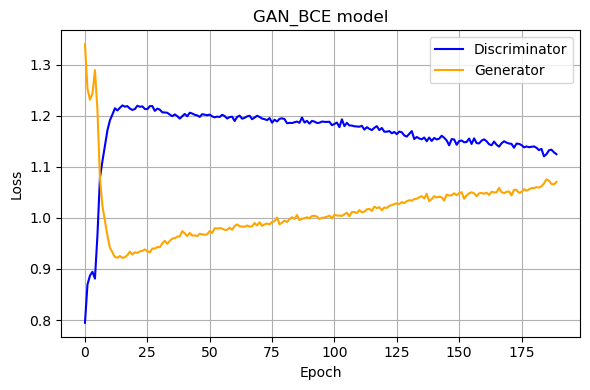

In [ ]:
# --- 초기 설정 ---
best_fid = float("inf")
patience = 5
counter = 0
should_stop = False  # <--- 변경된 점: 루프 탈출을 위한 플래그
model_name = "GAN_BCE"

D_losses = []
G_losses = []
# --- 학습 루프 ---
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    # tqdm을 loop 변수로 받아서 사용
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    generator.train()  # 에폭 시작 시 train 모드 명시
    for imgs, labels in loop:
        batch_size_current = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake = torch.zeros(batch_size_current, 1, device=device)

        # ---------------------
        #  판별자D 학습
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), valid)

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_imgs = generator(noise, labels)
        fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  생성자G 학습
        # ---------------------
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # 에폭 손실 누적 및 tqdm에 실시간 손실 표시
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        # loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    # <에폭마다 평균 손실 요약 출력
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    D_losses.append(avg_d_loss)
    G_losses.append(avg_g_loss)
    print(f"Avg D_loss: {avg_d_loss:.4f}, Avg G_loss: {avg_g_loss:.4f}")

    # 스케줄러: cosine Anealing
    scheduler_G.step()
    scheduler_D.step()
    # ----------------------------------------------------
    #  Epoch 종료 후 평가, 저장, 시각화
    # ----------------------------------------------------
    generator.eval()
    with torch.no_grad():
        # 5 에폭마다 샘플 이미지 저장
        if (epoch + 1) % 5 == 0:
            z = torch.randn(num_classes * 10, latent_dim).to(device)
            labels_to_sample = torch.LongTensor(
                np.array([num for _ in range(10) for num in range(num_classes)])
            ).to(device)
            sampled_imgs = generator(z, labels_to_sample)
            save_image(
                sampled_imgs.data,
                f"images/{model_name}_{epoch+1}.png",
                nrow=num_classes,
                normalize=True,
            )
            print(f"Saved sample images to images/{model_name}_{epoch+1}.png")

        # 10 에폭마다 FID 평가 및 시각화
        if (epoch + 1) % 10 == 0:
            # FID 평가 및 Early Stopping
            fid_score = calculate_fid(generator, val_loader, device)
            FID_TOTAL.append(fid_score)
            print(f"--> Current FID: {fid_score:.4f} | Best FID: {best_fid:.4f}")

            if fid_score < best_fid:
                best_fid = fid_score
                counter = 0
                torch.save(generator.state_dict(), "best_generator.pth")
                print("✨ New best model saved!")
            else:
                counter += 1
                print(f"Patience counter: {counter}/{patience}")
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    should_stop = True  # <--- 변경된 점: 플래그 설정

            # # 이미지 시각화
            # n_row, n_col = 3, num_classes
            # noise = torch.randn(n_row * n_col, latent_dim, device=device)
            # labels_sample = torch.arange(0, n_col, device=device).repeat(n_row)
            # gen_imgs = generator(noise, labels_sample).detach().cpu()

            # fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
            # for i in range(n_row):
            #     for j in range(n_col):
            #         idx = i * n_col + j
            #         axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap="gray")
            #         axs[i, j].axis("off")
            #         if i == 0:
            #             axs[i, j].set_title(idx_to_class[j], fontsize=10)
            # plt.tight_layout()
            # plt.show()

    # <--- 변경된 점: 루프 마지막에서 탈출 여부 확인
    if should_stop:
        break

# 학습 시각화
plt.figure(figsize=(6, 4))
plt.plot(D_losses, label="Discriminator", color="blue")
plt.plot(G_losses, label="Generator", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{model_name} model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# test set에서 최종 평가
calculate_fid(generator, test_loader, device)

Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:39<00:00,  7.97s/it]


⚪ FID Score: 20.312549925460644


np.float64(20.312549925460644)

In [9]:
# 메모리 정리 루틴
del generator
del discriminator
del optimizer_G
del optimizer_D

gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [2]:
# 모델 초기화
generator = Generator().to(device)
critic = Discriminator_Critic().to(device)

# WGAN에서 추천하는 Adam 세팅
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizer_D = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=NUM_EPOCHS, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=NUM_EPOCHS, eta_min=1e-6)

NameError: name 'Generator' is not defined

Epoch [1/500]: 100%|██████████| 211/211 [00:18<00:00, 11.39it/s]


D_loss: -6.7580  G_loss: -8.1168


Epoch [2/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -4.6443  G_loss: -8.6118


Epoch [3/500]: 100%|██████████| 211/211 [00:18<00:00, 11.48it/s]


D_loss: -4.0308  G_loss: -6.2545


Epoch [4/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -5.6241  G_loss: -2.6384


Epoch [5/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -5.9391  G_loss: -2.0888
Saved sample images to images/WGAN_GP_5.png


Epoch [6/500]: 100%|██████████| 211/211 [00:20<00:00, 10.25it/s]


D_loss: -6.6462  G_loss: -4.5329


Epoch [7/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -6.4628  G_loss: -4.3671


Epoch [8/500]: 100%|██████████| 211/211 [00:17<00:00, 11.75it/s]


D_loss: -6.4990  G_loss: -2.8584


Epoch [9/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -5.7501  G_loss: -4.0569


Epoch [10/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -5.6540  G_loss: -1.2024
Saved sample images to images/WGAN_GP_10.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 158.88615870868205
--> Current FID: 158.8862 | Best FID: inf
✨ New best model saved!


Epoch [11/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -5.2052  G_loss: -1.7560


Epoch [12/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -4.5009  G_loss: -1.7668


Epoch [13/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -4.7743  G_loss: -1.2913


Epoch [14/500]: 100%|██████████| 211/211 [00:18<00:00, 11.13it/s]


D_loss: -4.6010  G_loss: -1.0101


Epoch [15/500]: 100%|██████████| 211/211 [00:18<00:00, 11.60it/s]


D_loss: -4.2657  G_loss: 1.6509
Saved sample images to images/WGAN_GP_15.png


Epoch [16/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -4.1798  G_loss: -1.0829


Epoch [17/500]: 100%|██████████| 211/211 [00:17<00:00, 11.81it/s]


D_loss: -4.0921  G_loss: -0.2080


Epoch [18/500]: 100%|██████████| 211/211 [00:19<00:00, 10.96it/s]


D_loss: -4.1296  G_loss: 1.2992


Epoch [19/500]: 100%|██████████| 211/211 [00:18<00:00, 11.67it/s]


D_loss: -4.1657  G_loss: 0.9659


Epoch [20/500]: 100%|██████████| 211/211 [00:18<00:00, 11.58it/s]


D_loss: -4.2809  G_loss: 3.0192
Saved sample images to images/WGAN_GP_20.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


⚪ FID Score: 132.02547482569346
--> Current FID: 132.0255 | Best FID: 158.8862
✨ New best model saved!


Epoch [21/500]: 100%|██████████| 211/211 [00:19<00:00, 11.10it/s]


D_loss: -4.0651  G_loss: 3.4364


Epoch [22/500]: 100%|██████████| 211/211 [00:19<00:00, 11.00it/s]


D_loss: -3.9338  G_loss: 3.8920


Epoch [23/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -3.5809  G_loss: 2.4748


Epoch [24/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -3.5348  G_loss: 2.4322


Epoch [25/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -3.5060  G_loss: 3.1961
Saved sample images to images/WGAN_GP_25.png


Epoch [26/500]: 100%|██████████| 211/211 [00:18<00:00, 11.60it/s]


D_loss: -3.8098  G_loss: 2.5800


Epoch [27/500]: 100%|██████████| 211/211 [00:17<00:00, 11.82it/s]


D_loss: -3.5004  G_loss: 3.7191


Epoch [28/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -3.2231  G_loss: 3.0577


Epoch [29/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -3.1265  G_loss: 4.2385


Epoch [30/500]: 100%|██████████| 211/211 [00:18<00:00, 11.62it/s]


D_loss: -3.2301  G_loss: 4.0681
Saved sample images to images/WGAN_GP_30.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


⚪ FID Score: 124.33878005583995
--> Current FID: 124.3388 | Best FID: 132.0255
✨ New best model saved!


Epoch [31/500]: 100%|██████████| 211/211 [00:18<00:00, 11.25it/s]


D_loss: -3.2944  G_loss: 5.0094


Epoch [32/500]: 100%|██████████| 211/211 [00:18<00:00, 11.52it/s]


D_loss: -3.0229  G_loss: 4.3839


Epoch [33/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -3.0483  G_loss: 4.7803


Epoch [34/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -3.0768  G_loss: 5.2847


Epoch [35/500]: 100%|██████████| 211/211 [00:17<00:00, 11.81it/s]


D_loss: -2.8703  G_loss: 4.2050
Saved sample images to images/WGAN_GP_35.png


Epoch [36/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -2.7052  G_loss: 4.8518


Epoch [37/500]: 100%|██████████| 211/211 [00:17<00:00, 11.81it/s]


D_loss: -2.6252  G_loss: 3.9414


Epoch [38/500]: 100%|██████████| 211/211 [00:17<00:00, 11.74it/s]


D_loss: -2.8994  G_loss: 6.0189


Epoch [39/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -3.0087  G_loss: 4.9510


Epoch [40/500]: 100%|██████████| 211/211 [00:17<00:00, 11.75it/s]


D_loss: -2.8898  G_loss: 5.8911
Saved sample images to images/WGAN_GP_40.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


⚪ FID Score: 115.93401934265776
--> Current FID: 115.9340 | Best FID: 124.3388
✨ New best model saved!


Epoch [41/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -2.4619  G_loss: 5.2532


Epoch [42/500]: 100%|██████████| 211/211 [00:17<00:00, 11.78it/s]


D_loss: -3.0486  G_loss: 5.3017


Epoch [43/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -2.7015  G_loss: 5.4843


Epoch [44/500]: 100%|██████████| 211/211 [00:18<00:00, 11.18it/s]


D_loss: -2.6880  G_loss: 5.4319


Epoch [45/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -2.4241  G_loss: 4.0814
Saved sample images to images/WGAN_GP_45.png


Epoch [46/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -2.7591  G_loss: 6.7346


Epoch [47/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -2.3538  G_loss: 5.4563


Epoch [48/500]: 100%|██████████| 211/211 [00:18<00:00, 11.69it/s]


D_loss: -2.4750  G_loss: 5.9281


Epoch [49/500]: 100%|██████████| 211/211 [00:17<00:00, 11.73it/s]


D_loss: -2.4683  G_loss: 5.7543


Epoch [50/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.9377  G_loss: 5.3302
Saved sample images to images/WGAN_GP_50.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 113.4234473396526
--> Current FID: 113.4234 | Best FID: 115.9340
✨ New best model saved!


Epoch [51/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -2.4332  G_loss: 5.8063


Epoch [52/500]: 100%|██████████| 211/211 [00:19<00:00, 11.05it/s]


D_loss: -2.2281  G_loss: 5.1472


Epoch [53/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -2.0537  G_loss: 5.8792


Epoch [54/500]: 100%|██████████| 211/211 [00:17<00:00, 11.72it/s]


D_loss: -2.1949  G_loss: 5.8688


Epoch [55/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -2.3290  G_loss: 6.3308
Saved sample images to images/WGAN_GP_55.png


Epoch [56/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -2.0552  G_loss: 5.8217


Epoch [57/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -2.1140  G_loss: 6.7787


Epoch [58/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -1.8437  G_loss: 6.0986


Epoch [59/500]: 100%|██████████| 211/211 [00:18<00:00, 11.71it/s]


D_loss: -2.1512  G_loss: 6.5263


Epoch [60/500]: 100%|██████████| 211/211 [00:17<00:00, 11.82it/s]


D_loss: -2.1622  G_loss: 7.0514
Saved sample images to images/WGAN_GP_60.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 100.66166230426154
--> Current FID: 100.6617 | Best FID: 113.4234
✨ New best model saved!


Epoch [61/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -2.1845  G_loss: 6.3762


Epoch [62/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -2.3249  G_loss: 6.1176


Epoch [63/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -2.1765  G_loss: 6.4803


Epoch [64/500]: 100%|██████████| 211/211 [00:18<00:00, 11.72it/s]


D_loss: -2.0233  G_loss: 6.7490


Epoch [65/500]: 100%|██████████| 211/211 [00:18<00:00, 11.66it/s]


D_loss: -1.9925  G_loss: 6.8929
Saved sample images to images/WGAN_GP_65.png


Epoch [66/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -2.0127  G_loss: 7.4213


Epoch [67/500]: 100%|██████████| 211/211 [00:18<00:00, 11.67it/s]


D_loss: -1.6098  G_loss: 6.4088


Epoch [68/500]: 100%|██████████| 211/211 [00:17<00:00, 11.73it/s]


D_loss: -2.0608  G_loss: 6.3586


Epoch [69/500]: 100%|██████████| 211/211 [00:18<00:00, 11.66it/s]


D_loss: -2.0172  G_loss: 6.4451


Epoch [70/500]: 100%|██████████| 211/211 [00:18<00:00, 11.69it/s]


D_loss: -1.9147  G_loss: 7.3094
Saved sample images to images/WGAN_GP_70.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 90.41328537402711
--> Current FID: 90.4133 | Best FID: 100.6617
✨ New best model saved!


Epoch [71/500]: 100%|██████████| 211/211 [00:18<00:00, 11.22it/s]


D_loss: -1.7632  G_loss: 7.1613


Epoch [72/500]: 100%|██████████| 211/211 [00:17<00:00, 11.87it/s]


D_loss: -1.7451  G_loss: 7.2211


Epoch [73/500]: 100%|██████████| 211/211 [00:18<00:00, 11.71it/s]


D_loss: -1.9716  G_loss: 6.6710


Epoch [74/500]: 100%|██████████| 211/211 [00:20<00:00, 10.54it/s]


D_loss: -1.8911  G_loss: 6.2996


Epoch [75/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.7808  G_loss: 5.1696
Saved sample images to images/WGAN_GP_75.png


Epoch [76/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.8187  G_loss: 7.6885


Epoch [77/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.4986  G_loss: 5.6086


Epoch [78/500]: 100%|██████████| 211/211 [00:18<00:00, 11.26it/s]


D_loss: -1.6218  G_loss: 5.4026


Epoch [79/500]: 100%|██████████| 211/211 [00:18<00:00, 11.62it/s]


D_loss: -1.8638  G_loss: 6.9714


Epoch [80/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.7595  G_loss: 6.1894
Saved sample images to images/WGAN_GP_80.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 84.93332238335356
--> Current FID: 84.9333 | Best FID: 90.4133
✨ New best model saved!


Epoch [81/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.6468  G_loss: 6.3352


Epoch [82/500]: 100%|██████████| 211/211 [00:18<00:00, 11.31it/s]


D_loss: -1.9168  G_loss: 6.3805


Epoch [83/500]: 100%|██████████| 211/211 [00:17<00:00, 11.74it/s]


D_loss: -1.8924  G_loss: 7.0612


Epoch [84/500]: 100%|██████████| 211/211 [00:18<00:00, 11.72it/s]


D_loss: -2.0784  G_loss: 7.6184


Epoch [85/500]: 100%|██████████| 211/211 [00:17<00:00, 11.79it/s]


D_loss: -1.6946  G_loss: 7.1521
Saved sample images to images/WGAN_GP_85.png


Epoch [86/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.6903  G_loss: 6.0852


Epoch [87/500]: 100%|██████████| 211/211 [00:18<00:00, 11.67it/s]


D_loss: -1.7631  G_loss: 6.3682


Epoch [88/500]: 100%|██████████| 211/211 [00:18<00:00, 11.70it/s]


D_loss: -1.9534  G_loss: 6.8576


Epoch [89/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.9837  G_loss: 8.1253


Epoch [90/500]: 100%|██████████| 211/211 [00:18<00:00, 11.68it/s]


D_loss: -1.5699  G_loss: 6.9765
Saved sample images to images/WGAN_GP_90.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 79.72060777072397
--> Current FID: 79.7206 | Best FID: 84.9333
✨ New best model saved!


Epoch [91/500]: 100%|██████████| 211/211 [00:19<00:00, 10.78it/s]


D_loss: -1.5761  G_loss: 7.0258


Epoch [92/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.6536  G_loss: 7.5187


Epoch [93/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -1.6648  G_loss: 7.8284


Epoch [94/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.8410  G_loss: 8.3195


Epoch [95/500]: 100%|██████████| 211/211 [00:18<00:00, 11.58it/s]


D_loss: -1.7437  G_loss: 7.4583
Saved sample images to images/WGAN_GP_95.png


Epoch [96/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.7294  G_loss: 8.4998


Epoch [97/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.5732  G_loss: 8.3020


Epoch [98/500]: 100%|██████████| 211/211 [00:17<00:00, 11.89it/s]


D_loss: -1.7094  G_loss: 8.0453


Epoch [99/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.8191  G_loss: 7.3419


Epoch [100/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.5572  G_loss: 8.9212
Saved sample images to images/WGAN_GP_100.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 76.47454152577848
--> Current FID: 76.4745 | Best FID: 79.7206
✨ New best model saved!


Epoch [101/500]: 100%|██████████| 211/211 [00:20<00:00, 10.40it/s]


D_loss: -1.3352  G_loss: 8.2365


Epoch [102/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.5270  G_loss: 8.2312


Epoch [103/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.6034  G_loss: 6.8630


Epoch [104/500]: 100%|██████████| 211/211 [00:18<00:00, 11.62it/s]


D_loss: -1.6071  G_loss: 7.3550


Epoch [105/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.8596  G_loss: 8.5957
Saved sample images to images/WGAN_GP_105.png


Epoch [106/500]: 100%|██████████| 211/211 [00:18<00:00, 11.68it/s]


D_loss: -1.7346  G_loss: 7.9638


Epoch [107/500]: 100%|██████████| 211/211 [00:17<00:00, 11.76it/s]


D_loss: -1.5942  G_loss: 8.0598


Epoch [108/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.5020  G_loss: 9.8985


Epoch [109/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -1.6910  G_loss: 8.6441


Epoch [110/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.5167  G_loss: 9.2829
Saved sample images to images/WGAN_GP_110.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 73.71699611891111
--> Current FID: 73.7170 | Best FID: 76.4745
✨ New best model saved!


Epoch [111/500]: 100%|██████████| 211/211 [00:18<00:00, 11.52it/s]


D_loss: -1.6383  G_loss: 7.5317


Epoch [112/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.5060  G_loss: 8.1299


Epoch [113/500]: 100%|██████████| 211/211 [00:18<00:00, 11.58it/s]


D_loss: -1.5673  G_loss: 9.2060


Epoch [114/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -1.6492  G_loss: 8.0448


Epoch [115/500]: 100%|██████████| 211/211 [00:17<00:00, 11.78it/s]


D_loss: -1.6610  G_loss: 7.3570
Saved sample images to images/WGAN_GP_115.png


Epoch [116/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.5907  G_loss: 7.7465


Epoch [117/500]: 100%|██████████| 211/211 [00:18<00:00, 11.66it/s]


D_loss: -1.4717  G_loss: 8.5477


Epoch [118/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.5317  G_loss: 8.0794


Epoch [119/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -1.5561  G_loss: 8.4159


Epoch [120/500]: 100%|██████████| 211/211 [00:18<00:00, 11.48it/s]


D_loss: -1.5513  G_loss: 7.8147
Saved sample images to images/WGAN_GP_120.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 72.22959216740318
--> Current FID: 72.2296 | Best FID: 73.7170
✨ New best model saved!


Epoch [121/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.8920  G_loss: 9.8614


Epoch [122/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.5529  G_loss: 9.2184


Epoch [123/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.3845  G_loss: 8.8605


Epoch [124/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.5227  G_loss: 9.4633


Epoch [125/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -1.5636  G_loss: 8.7199
Saved sample images to images/WGAN_GP_125.png


Epoch [126/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.5434  G_loss: 7.2652


Epoch [127/500]: 100%|██████████| 211/211 [00:17<00:00, 11.74it/s]


D_loss: -1.7327  G_loss: 9.8580


Epoch [128/500]: 100%|██████████| 211/211 [00:18<00:00, 11.15it/s]


D_loss: -1.4285  G_loss: 8.3741


Epoch [129/500]: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


D_loss: -1.6289  G_loss: 9.4380


Epoch [130/500]: 100%|██████████| 211/211 [00:18<00:00, 11.52it/s]


D_loss: -1.5129  G_loss: 9.1072
Saved sample images to images/WGAN_GP_130.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 71.86050773108946
--> Current FID: 71.8605 | Best FID: 72.2296
✨ New best model saved!


Epoch [131/500]: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


D_loss: -1.5564  G_loss: 9.6049


Epoch [132/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.3280  G_loss: 8.0461


Epoch [133/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.4334  G_loss: 7.5016


Epoch [134/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.4919  G_loss: 8.2385


Epoch [135/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -1.6194  G_loss: 9.7970
Saved sample images to images/WGAN_GP_135.png


Epoch [136/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.6916  G_loss: 10.0090


Epoch [137/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.3300  G_loss: 8.7354


Epoch [138/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.6476  G_loss: 8.5959


Epoch [139/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -1.3636  G_loss: 9.7056


Epoch [140/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.3586  G_loss: 10.2340
Saved sample images to images/WGAN_GP_140.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 67.86677207508012
--> Current FID: 67.8668 | Best FID: 71.8605
✨ New best model saved!


Epoch [141/500]: 100%|██████████| 211/211 [00:20<00:00, 10.37it/s]


D_loss: -1.4510  G_loss: 9.0588


Epoch [142/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.4981  G_loss: 8.8674


Epoch [143/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.4015  G_loss: 9.2702


Epoch [144/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.4684  G_loss: 9.2605


Epoch [145/500]: 100%|██████████| 211/211 [00:18<00:00, 11.68it/s]


D_loss: -1.4227  G_loss: 8.2073
Saved sample images to images/WGAN_GP_145.png


Epoch [146/500]: 100%|██████████| 211/211 [00:18<00:00, 11.12it/s]


D_loss: -1.5534  G_loss: 10.1777


Epoch [147/500]: 100%|██████████| 211/211 [00:17<00:00, 11.77it/s]


D_loss: -1.7301  G_loss: 10.1113


Epoch [148/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -1.3912  G_loss: 9.0017


Epoch [149/500]: 100%|██████████| 211/211 [00:17<00:00, 11.78it/s]


D_loss: -1.3156  G_loss: 9.5664


Epoch [150/500]: 100%|██████████| 211/211 [00:18<00:00, 11.60it/s]


D_loss: -1.7121  G_loss: 9.0310
Saved sample images to images/WGAN_GP_150.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 68.49632808359564
--> Current FID: 68.4963 | Best FID: 67.8668
Patience counter: 1/5


Epoch [151/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.3510  G_loss: 9.2406


Epoch [152/500]: 100%|██████████| 211/211 [00:18<00:00, 11.26it/s]


D_loss: -1.4824  G_loss: 8.8745


Epoch [153/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.2722  G_loss: 9.0184


Epoch [154/500]: 100%|██████████| 211/211 [00:18<00:00, 11.66it/s]


D_loss: -1.5901  G_loss: 9.6540


Epoch [155/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.5341  G_loss: 9.9221
Saved sample images to images/WGAN_GP_155.png


Epoch [156/500]: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


D_loss: -1.5180  G_loss: 9.5213


Epoch [157/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -1.2380  G_loss: 9.7319


Epoch [158/500]: 100%|██████████| 211/211 [00:18<00:00, 11.69it/s]


D_loss: -1.4656  G_loss: 10.0213


Epoch [159/500]: 100%|██████████| 211/211 [00:18<00:00, 11.52it/s]


D_loss: -1.4112  G_loss: 9.7037


Epoch [160/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.4672  G_loss: 8.9629
Saved sample images to images/WGAN_GP_160.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 67.86635504714434
--> Current FID: 67.8664 | Best FID: 67.8668
✨ New best model saved!


Epoch [161/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.6408  G_loss: 10.5829


Epoch [162/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.3887  G_loss: 9.0891


Epoch [163/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.2950  G_loss: 9.7870


Epoch [164/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.3224  G_loss: 8.7627


Epoch [165/500]: 100%|██████████| 211/211 [00:18<00:00, 11.30it/s]


D_loss: -1.4919  G_loss: 10.3881
Saved sample images to images/WGAN_GP_165.png


Epoch [166/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.3595  G_loss: 9.0184


Epoch [167/500]: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


D_loss: -1.4454  G_loss: 10.8173


Epoch [168/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.4543  G_loss: 10.5881


Epoch [169/500]: 100%|██████████| 211/211 [00:18<00:00, 11.60it/s]


D_loss: -1.2279  G_loss: 10.2989


Epoch [170/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.3881  G_loss: 9.7340
Saved sample images to images/WGAN_GP_170.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 68.04938297549512
--> Current FID: 68.0494 | Best FID: 67.8664
Patience counter: 1/5


Epoch [171/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.4786  G_loss: 10.8090


Epoch [172/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.5705  G_loss: 8.8699


Epoch [173/500]: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


D_loss: -1.5799  G_loss: 10.2045


Epoch [174/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.3615  G_loss: 9.0971


Epoch [175/500]: 100%|██████████| 211/211 [00:17<00:00, 11.77it/s]


D_loss: -1.5727  G_loss: 9.6733
Saved sample images to images/WGAN_GP_175.png


Epoch [176/500]: 100%|██████████| 211/211 [00:18<00:00, 11.62it/s]


D_loss: -1.2035  G_loss: 9.4634


Epoch [177/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.4621  G_loss: 10.0287


Epoch [178/500]: 100%|██████████| 211/211 [00:18<00:00, 11.48it/s]


D_loss: -1.1276  G_loss: 10.2112


Epoch [179/500]: 100%|██████████| 211/211 [00:18<00:00, 11.58it/s]


D_loss: -1.5256  G_loss: 10.2842


Epoch [180/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.5727  G_loss: 9.6371
Saved sample images to images/WGAN_GP_180.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 66.31323151042716
--> Current FID: 66.3132 | Best FID: 67.8664
✨ New best model saved!


Epoch [181/500]: 100%|██████████| 211/211 [00:18<00:00, 11.39it/s]


D_loss: -1.5200  G_loss: 10.0355


Epoch [182/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.5809  G_loss: 9.9521


Epoch [183/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -1.2531  G_loss: 9.3575


Epoch [184/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.3936  G_loss: 9.1391


Epoch [185/500]: 100%|██████████| 211/211 [00:18<00:00, 11.12it/s]


D_loss: -1.5138  G_loss: 10.9488
Saved sample images to images/WGAN_GP_185.png


Epoch [186/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.4681  G_loss: 10.0708


Epoch [187/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -1.6101  G_loss: 9.2495


Epoch [188/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.1253  G_loss: 9.9891


Epoch [189/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.4418  G_loss: 9.8048


Epoch [190/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.3466  G_loss: 10.3638
Saved sample images to images/WGAN_GP_190.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 65.7336787471198
--> Current FID: 65.7337 | Best FID: 66.3132
✨ New best model saved!


Epoch [191/500]: 100%|██████████| 211/211 [00:18<00:00, 11.34it/s]


D_loss: -1.2529  G_loss: 9.7659


Epoch [192/500]: 100%|██████████| 211/211 [00:18<00:00, 11.31it/s]


D_loss: -1.3723  G_loss: 10.9851


Epoch [193/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.3767  G_loss: 9.6372


Epoch [194/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.4774  G_loss: 10.4691


Epoch [195/500]: 100%|██████████| 211/211 [00:18<00:00, 11.44it/s]


D_loss: -1.2087  G_loss: 9.6591
Saved sample images to images/WGAN_GP_195.png


Epoch [196/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.3842  G_loss: 9.6513


Epoch [197/500]: 100%|██████████| 211/211 [00:18<00:00, 11.63it/s]


D_loss: -1.4235  G_loss: 10.3711


Epoch [198/500]: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


D_loss: -1.2376  G_loss: 10.7025


Epoch [199/500]: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


D_loss: -1.3390  G_loss: 9.8348


Epoch [200/500]: 100%|██████████| 211/211 [00:18<00:00, 11.31it/s]


D_loss: -1.4033  G_loss: 10.7837
Saved sample images to images/WGAN_GP_200.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 65.76029643477551
--> Current FID: 65.7603 | Best FID: 65.7337
Patience counter: 1/5


Epoch [201/500]: 100%|██████████| 211/211 [00:18<00:00, 11.14it/s]


D_loss: -1.3432  G_loss: 9.9102


Epoch [202/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.2811  G_loss: 8.7219


Epoch [203/500]: 100%|██████████| 211/211 [00:18<00:00, 11.21it/s]


D_loss: -1.4471  G_loss: 10.1730


Epoch [204/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.4692  G_loss: 9.6730


Epoch [205/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -1.4095  G_loss: 10.3628
Saved sample images to images/WGAN_GP_205.png


Epoch [206/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.4037  G_loss: 10.2024


Epoch [207/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.2378  G_loss: 10.5171


Epoch [208/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.4394  G_loss: 10.1663


Epoch [209/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.4241  G_loss: 10.2210


Epoch [210/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.2183  G_loss: 10.2085
Saved sample images to images/WGAN_GP_210.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


⚪ FID Score: 64.1228188997909
--> Current FID: 64.1228 | Best FID: 65.7337
✨ New best model saved!


Epoch [211/500]: 100%|██████████| 211/211 [00:19<00:00, 11.08it/s]


D_loss: -1.3768  G_loss: 10.3502


Epoch [212/500]: 100%|██████████| 211/211 [00:18<00:00, 11.39it/s]


D_loss: -1.1843  G_loss: 10.5401


Epoch [213/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.2547  G_loss: 9.5797


Epoch [214/500]: 100%|██████████| 211/211 [00:19<00:00, 10.97it/s]


D_loss: -1.3981  G_loss: 10.1649


Epoch [215/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.4442  G_loss: 10.8655
Saved sample images to images/WGAN_GP_215.png


Epoch [216/500]: 100%|██████████| 211/211 [00:18<00:00, 11.20it/s]


D_loss: -1.2850  G_loss: 8.9402


Epoch [217/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -1.4310  G_loss: 10.0316


Epoch [218/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.1474  G_loss: 10.2338


Epoch [219/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.5126  G_loss: 11.0518


Epoch [220/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.3223  G_loss: 11.0976
Saved sample images to images/WGAN_GP_220.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


⚪ FID Score: 64.56157690162456
--> Current FID: 64.5616 | Best FID: 64.1228
Patience counter: 1/5


Epoch [221/500]: 100%|██████████| 211/211 [00:18<00:00, 11.23it/s]


D_loss: -1.3875  G_loss: 10.8354


Epoch [222/500]: 100%|██████████| 211/211 [00:19<00:00, 10.98it/s]


D_loss: -1.2929  G_loss: 10.2034


Epoch [223/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.1042  G_loss: 9.6145


Epoch [224/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.3252  G_loss: 10.4708


Epoch [225/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.4698  G_loss: 10.4511
Saved sample images to images/WGAN_GP_225.png


Epoch [226/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -1.2899  G_loss: 11.8164


Epoch [227/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.3080  G_loss: 10.5200


Epoch [228/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.4649  G_loss: 10.8996


Epoch [229/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.2764  G_loss: 10.7874


Epoch [230/500]: 100%|██████████| 211/211 [00:19<00:00, 11.04it/s]


D_loss: -1.4077  G_loss: 10.4680
Saved sample images to images/WGAN_GP_230.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:37<00:00,  7.85s/it]


⚪ FID Score: 64.03574952806866
--> Current FID: 64.0357 | Best FID: 64.1228
✨ New best model saved!


Epoch [231/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.3986  G_loss: 10.9477


Epoch [232/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.3043  G_loss: 9.6318


Epoch [233/500]: 100%|██████████| 211/211 [00:18<00:00, 11.15it/s]


D_loss: -1.4305  G_loss: 10.6271


Epoch [234/500]: 100%|██████████| 211/211 [00:19<00:00, 10.94it/s]


D_loss: -1.4451  G_loss: 10.3723


Epoch [235/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.2502  G_loss: 10.5077
Saved sample images to images/WGAN_GP_235.png


Epoch [236/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.4330  G_loss: 9.8595


Epoch [237/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.3816  G_loss: 9.9870


Epoch [238/500]: 100%|██████████| 211/211 [00:18<00:00, 11.48it/s]


D_loss: -1.3582  G_loss: 11.2280


Epoch [239/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.2493  G_loss: 9.7995


Epoch [240/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.2056  G_loss: 10.4521
Saved sample images to images/WGAN_GP_240.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 61.92286931207087
--> Current FID: 61.9229 | Best FID: 64.0357
✨ New best model saved!


Epoch [241/500]: 100%|██████████| 211/211 [00:18<00:00, 11.34it/s]


D_loss: -1.2588  G_loss: 10.5020


Epoch [242/500]: 100%|██████████| 211/211 [00:18<00:00, 11.13it/s]


D_loss: -1.3723  G_loss: 9.9934


Epoch [243/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.2602  G_loss: 9.7939


Epoch [244/500]: 100%|██████████| 211/211 [00:18<00:00, 11.15it/s]


D_loss: -1.3000  G_loss: 10.2144


Epoch [245/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.3414  G_loss: 10.0605
Saved sample images to images/WGAN_GP_245.png


Epoch [246/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.4804  G_loss: 10.9012


Epoch [247/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.2291  G_loss: 10.6942


Epoch [248/500]: 100%|██████████| 211/211 [00:19<00:00, 11.05it/s]


D_loss: -1.3498  G_loss: 9.9721


Epoch [249/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.3483  G_loss: 10.3960


Epoch [250/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.4559  G_loss: 10.7173
Saved sample images to images/WGAN_GP_250.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 62.37385422439377
--> Current FID: 62.3739 | Best FID: 61.9229
Patience counter: 1/5


Epoch [251/500]: 100%|██████████| 211/211 [00:18<00:00, 11.19it/s]


D_loss: -1.2560  G_loss: 9.8002


Epoch [252/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.3984  G_loss: 10.1977


Epoch [253/500]: 100%|██████████| 211/211 [00:18<00:00, 11.12it/s]


D_loss: -1.2617  G_loss: 10.0523


Epoch [254/500]: 100%|██████████| 211/211 [00:18<00:00, 11.20it/s]


D_loss: -1.4278  G_loss: 10.3528


Epoch [255/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.3604  G_loss: 10.4878
Saved sample images to images/WGAN_GP_255.png


Epoch [256/500]: 100%|██████████| 211/211 [00:19<00:00, 10.90it/s]


D_loss: -1.3995  G_loss: 11.2411


Epoch [257/500]: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


D_loss: -1.3197  G_loss: 10.0339


Epoch [258/500]: 100%|██████████| 211/211 [00:19<00:00, 10.98it/s]


D_loss: -1.1841  G_loss: 11.3088


Epoch [259/500]: 100%|██████████| 211/211 [00:18<00:00, 11.23it/s]


D_loss: -1.2336  G_loss: 10.5647


Epoch [260/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.3045  G_loss: 10.1099
Saved sample images to images/WGAN_GP_260.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 62.838476387062826
--> Current FID: 62.8385 | Best FID: 61.9229
Patience counter: 2/5


Epoch [261/500]: 100%|██████████| 211/211 [00:18<00:00, 11.23it/s]


D_loss: -1.2086  G_loss: 9.9673


Epoch [262/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.1711  G_loss: 11.4221


Epoch [263/500]: 100%|██████████| 211/211 [00:18<00:00, 11.24it/s]


D_loss: -1.3496  G_loss: 10.5271


Epoch [264/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.4502  G_loss: 12.3164


Epoch [265/500]: 100%|██████████| 211/211 [00:18<00:00, 11.20it/s]


D_loss: -1.3446  G_loss: 11.1530
Saved sample images to images/WGAN_GP_265.png


Epoch [266/500]: 100%|██████████| 211/211 [00:18<00:00, 11.11it/s]


D_loss: -1.2669  G_loss: 10.2463


Epoch [267/500]: 100%|██████████| 211/211 [00:18<00:00, 11.22it/s]


D_loss: -1.4344  G_loss: 12.1323


Epoch [268/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.1916  G_loss: 11.4665


Epoch [269/500]: 100%|██████████| 211/211 [00:18<00:00, 11.14it/s]


D_loss: -1.3586  G_loss: 10.6582


Epoch [270/500]: 100%|██████████| 211/211 [00:18<00:00, 11.25it/s]


D_loss: -1.4123  G_loss: 10.8920
Saved sample images to images/WGAN_GP_270.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 62.426789075846216
--> Current FID: 62.4268 | Best FID: 61.9229
Patience counter: 3/5


Epoch [271/500]: 100%|██████████| 211/211 [00:18<00:00, 11.25it/s]


D_loss: -1.2843  G_loss: 10.8718


Epoch [272/500]: 100%|██████████| 211/211 [00:19<00:00, 11.06it/s]


D_loss: -1.2375  G_loss: 10.9617


Epoch [273/500]: 100%|██████████| 211/211 [00:19<00:00, 11.09it/s]


D_loss: -1.1222  G_loss: 11.2061


Epoch [274/500]: 100%|██████████| 211/211 [00:19<00:00, 11.07it/s]


D_loss: -1.2027  G_loss: 11.1205


Epoch [275/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.2704  G_loss: 10.1575
Saved sample images to images/WGAN_GP_275.png


Epoch [276/500]: 100%|██████████| 211/211 [00:18<00:00, 11.16it/s]


D_loss: -1.3933  G_loss: 10.8746


Epoch [277/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.2882  G_loss: 10.7468


Epoch [278/500]: 100%|██████████| 211/211 [00:18<00:00, 11.21it/s]


D_loss: -1.1463  G_loss: 11.1055


Epoch [279/500]: 100%|██████████| 211/211 [00:18<00:00, 11.21it/s]


D_loss: -1.3049  G_loss: 11.0540


Epoch [280/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.1496  G_loss: 11.0469
Saved sample images to images/WGAN_GP_280.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


⚪ FID Score: 63.46852504356417
--> Current FID: 63.4685 | Best FID: 61.9229
Patience counter: 4/5


Epoch [281/500]: 100%|██████████| 211/211 [00:18<00:00, 11.12it/s]


D_loss: -1.1650  G_loss: 11.0686


Epoch [282/500]: 100%|██████████| 211/211 [00:19<00:00, 11.01it/s]


D_loss: -1.1813  G_loss: 11.3749


Epoch [283/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.1784  G_loss: 10.8982


Epoch [284/500]: 100%|██████████| 211/211 [00:18<00:00, 11.20it/s]


D_loss: -1.2734  G_loss: 11.0197


Epoch [285/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.3777  G_loss: 11.7963
Saved sample images to images/WGAN_GP_285.png


Epoch [286/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.2785  G_loss: 11.3795


Epoch [287/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.3754  G_loss: 11.1559


Epoch [288/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.3186  G_loss: 11.2480


Epoch [289/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.0818  G_loss: 11.1277


Epoch [290/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.4576  G_loss: 11.3466
Saved sample images to images/WGAN_GP_290.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 61.74450646153366
--> Current FID: 61.7445 | Best FID: 61.9229
✨ New best model saved!


Epoch [291/500]: 100%|██████████| 211/211 [00:19<00:00, 11.03it/s]


D_loss: -1.3336  G_loss: 10.9057


Epoch [292/500]: 100%|██████████| 211/211 [00:18<00:00, 11.14it/s]


D_loss: -1.3051  G_loss: 11.9493


Epoch [293/500]: 100%|██████████| 211/211 [00:18<00:00, 11.17it/s]


D_loss: -1.5402  G_loss: 11.5685


Epoch [294/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.2357  G_loss: 9.9640


Epoch [295/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.3535  G_loss: 12.0039
Saved sample images to images/WGAN_GP_295.png


Epoch [296/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.2312  G_loss: 11.2779


Epoch [297/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -1.2864  G_loss: 10.9048


Epoch [298/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.3089  G_loss: 10.7581


Epoch [299/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.1338  G_loss: 10.7095


Epoch [300/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.2144  G_loss: 10.8665
Saved sample images to images/WGAN_GP_300.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.91294051319261
--> Current FID: 60.9129 | Best FID: 61.7445
✨ New best model saved!


Epoch [301/500]: 100%|██████████| 211/211 [00:18<00:00, 11.59it/s]


D_loss: -1.4271  G_loss: 11.0123


Epoch [302/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.3610  G_loss: 11.7672


Epoch [303/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.2499  G_loss: 11.6402


Epoch [304/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.2323  G_loss: 10.9925


Epoch [305/500]: 100%|██████████| 211/211 [00:18<00:00, 11.54it/s]


D_loss: -1.2525  G_loss: 10.5234
Saved sample images to images/WGAN_GP_305.png


Epoch [306/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.2750  G_loss: 10.5891


Epoch [307/500]: 100%|██████████| 211/211 [00:19<00:00, 10.92it/s]


D_loss: -1.1798  G_loss: 10.9390


Epoch [308/500]: 100%|██████████| 211/211 [00:18<00:00, 11.21it/s]


D_loss: -1.4647  G_loss: 10.6308


Epoch [309/500]: 100%|██████████| 211/211 [00:20<00:00, 10.32it/s]


D_loss: -1.3878  G_loss: 10.9333


Epoch [310/500]: 100%|██████████| 211/211 [00:21<00:00,  9.81it/s]


D_loss: -1.3108  G_loss: 11.3924
Saved sample images to images/WGAN_GP_310.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.280495131163775
--> Current FID: 60.2805 | Best FID: 60.9129
✨ New best model saved!


Epoch [311/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.3154  G_loss: 11.4406


Epoch [312/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.2260  G_loss: 11.4979


Epoch [313/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.3988  G_loss: 11.9134


Epoch [314/500]: 100%|██████████| 211/211 [00:19<00:00, 10.90it/s]


D_loss: -1.2584  G_loss: 11.8157


Epoch [315/500]: 100%|██████████| 211/211 [00:19<00:00, 11.07it/s]


D_loss: -1.2075  G_loss: 11.3046
Saved sample images to images/WGAN_GP_315.png


Epoch [316/500]: 100%|██████████| 211/211 [00:18<00:00, 11.23it/s]


D_loss: -1.3521  G_loss: 11.2419


Epoch [317/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.2938  G_loss: 10.9603


Epoch [318/500]: 100%|██████████| 211/211 [00:19<00:00, 10.98it/s]


D_loss: -1.1709  G_loss: 10.7145


Epoch [319/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.3251  G_loss: 11.4591


Epoch [320/500]: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


D_loss: -1.3289  G_loss: 11.2519
Saved sample images to images/WGAN_GP_320.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.82s/it]


⚪ FID Score: 61.882904131214445
--> Current FID: 61.8829 | Best FID: 60.2805
Patience counter: 1/5


Epoch [321/500]: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


D_loss: -1.3408  G_loss: 10.9018


Epoch [322/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.2809  G_loss: 11.6486


Epoch [323/500]: 100%|██████████| 211/211 [00:18<00:00, 11.36it/s]


D_loss: -1.2516  G_loss: 10.8213


Epoch [324/500]: 100%|██████████| 211/211 [00:18<00:00, 11.34it/s]


D_loss: -1.3380  G_loss: 10.7070


Epoch [325/500]: 100%|██████████| 211/211 [00:19<00:00, 11.03it/s]


D_loss: -1.3437  G_loss: 11.1996
Saved sample images to images/WGAN_GP_325.png


Epoch [326/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -1.3824  G_loss: 11.0141


Epoch [327/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.2649  G_loss: 11.6047


Epoch [328/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.2577  G_loss: 11.3571


Epoch [329/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.3315  G_loss: 11.1068


Epoch [330/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.3740  G_loss: 10.8878
Saved sample images to images/WGAN_GP_330.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 61.692048728096495
--> Current FID: 61.6920 | Best FID: 60.2805
Patience counter: 2/5


Epoch [331/500]: 100%|██████████| 211/211 [00:18<00:00, 11.31it/s]


D_loss: -1.1299  G_loss: 11.0069


Epoch [332/500]: 100%|██████████| 211/211 [00:18<00:00, 11.57it/s]


D_loss: -1.4104  G_loss: 11.2570


Epoch [333/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.2748  G_loss: 11.2735


Epoch [334/500]: 100%|██████████| 211/211 [00:18<00:00, 11.53it/s]


D_loss: -1.3523  G_loss: 11.2975


Epoch [335/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.3185  G_loss: 11.1377
Saved sample images to images/WGAN_GP_335.png


Epoch [336/500]: 100%|██████████| 211/211 [00:19<00:00, 10.95it/s]


D_loss: -1.2011  G_loss: 10.6999


Epoch [337/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.3406  G_loss: 10.8210


Epoch [338/500]: 100%|██████████| 211/211 [00:19<00:00, 10.92it/s]


D_loss: -1.2681  G_loss: 10.8229


Epoch [339/500]: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


D_loss: -1.3289  G_loss: 11.3948


Epoch [340/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.3251  G_loss: 11.3247
Saved sample images to images/WGAN_GP_340.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.93403633414101
--> Current FID: 59.9340 | Best FID: 60.2805
✨ New best model saved!


Epoch [341/500]: 100%|██████████| 211/211 [00:18<00:00, 11.17it/s]


D_loss: -1.5783  G_loss: 11.7310


Epoch [342/500]: 100%|██████████| 211/211 [00:18<00:00, 11.47it/s]


D_loss: -1.1485  G_loss: 11.2266


Epoch [343/500]: 100%|██████████| 211/211 [00:18<00:00, 11.34it/s]


D_loss: -1.3622  G_loss: 11.6399


Epoch [344/500]: 100%|██████████| 211/211 [00:18<00:00, 11.20it/s]


D_loss: -1.1583  G_loss: 11.2649


Epoch [345/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.2951  G_loss: 11.1903
Saved sample images to images/WGAN_GP_345.png


Epoch [346/500]: 100%|██████████| 211/211 [00:19<00:00, 11.04it/s]


D_loss: -1.2980  G_loss: 11.3625


Epoch [347/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.2375  G_loss: 10.8620


Epoch [348/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.3095  G_loss: 10.9837


Epoch [349/500]: 100%|██████████| 211/211 [00:18<00:00, 11.14it/s]


D_loss: -1.3228  G_loss: 11.1329


Epoch [350/500]: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


D_loss: -1.0973  G_loss: 10.8578
Saved sample images to images/WGAN_GP_350.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.93454526310063
--> Current FID: 59.9345 | Best FID: 59.9340
Patience counter: 1/5


Epoch [351/500]: 100%|██████████| 211/211 [00:18<00:00, 11.25it/s]


D_loss: -1.4228  G_loss: 11.5456


Epoch [352/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.4351  G_loss: 11.2710


Epoch [353/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.1931  G_loss: 11.4308


Epoch [354/500]: 100%|██████████| 211/211 [00:18<00:00, 11.28it/s]


D_loss: -1.1958  G_loss: 11.2187


Epoch [355/500]: 100%|██████████| 211/211 [00:18<00:00, 11.62it/s]


D_loss: -1.2109  G_loss: 10.8808
Saved sample images to images/WGAN_GP_355.png


Epoch [356/500]: 100%|██████████| 211/211 [00:19<00:00, 11.05it/s]


D_loss: -1.1777  G_loss: 11.0757


Epoch [357/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.1917  G_loss: 11.4863


Epoch [358/500]: 100%|██████████| 211/211 [00:18<00:00, 11.50it/s]


D_loss: -1.1217  G_loss: 10.8858


Epoch [359/500]: 100%|██████████| 211/211 [00:18<00:00, 11.32it/s]


D_loss: -1.3211  G_loss: 11.5163


Epoch [360/500]: 100%|██████████| 211/211 [00:18<00:00, 11.42it/s]


D_loss: -1.2417  G_loss: 11.4184
Saved sample images to images/WGAN_GP_360.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.683983404728
--> Current FID: 59.6840 | Best FID: 59.9340
✨ New best model saved!


Epoch [361/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.4607  G_loss: 11.1723


Epoch [362/500]: 100%|██████████| 211/211 [00:18<00:00, 11.18it/s]


D_loss: -1.2913  G_loss: 10.9102


Epoch [363/500]: 100%|██████████| 211/211 [00:18<00:00, 11.26it/s]


D_loss: -1.1977  G_loss: 10.7394


Epoch [364/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.3613  G_loss: 11.2000


Epoch [365/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.2037  G_loss: 11.7757
Saved sample images to images/WGAN_GP_365.png


Epoch [366/500]: 100%|██████████| 211/211 [00:19<00:00, 11.04it/s]


D_loss: -1.4680  G_loss: 10.9601


Epoch [367/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.3670  G_loss: 11.1032


Epoch [368/500]: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


D_loss: -1.1857  G_loss: 10.7122


Epoch [369/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.2277  G_loss: 11.3634


Epoch [370/500]: 100%|██████████| 211/211 [00:17<00:00, 11.75it/s]


D_loss: -1.1424  G_loss: 11.3415
Saved sample images to images/WGAN_GP_370.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.50777276656919
--> Current FID: 59.5078 | Best FID: 59.6840
✨ New best model saved!


Epoch [371/500]: 100%|██████████| 211/211 [00:18<00:00, 11.30it/s]


D_loss: -1.2641  G_loss: 11.8256


Epoch [372/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.1844  G_loss: 11.4608


Epoch [373/500]: 100%|██████████| 211/211 [00:18<00:00, 11.39it/s]


D_loss: -1.3182  G_loss: 11.4672


Epoch [374/500]: 100%|██████████| 211/211 [00:18<00:00, 11.16it/s]


D_loss: -1.1124  G_loss: 10.9447


Epoch [375/500]: 100%|██████████| 211/211 [00:21<00:00,  9.97it/s]


D_loss: -1.2618  G_loss: 11.3934
Saved sample images to images/WGAN_GP_375.png


Epoch [376/500]: 100%|██████████| 211/211 [00:19<00:00, 10.85it/s]


D_loss: -1.2186  G_loss: 11.4901


Epoch [377/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -1.1768  G_loss: 11.0123


Epoch [378/500]: 100%|██████████| 211/211 [00:18<00:00, 11.71it/s]


D_loss: -1.2135  G_loss: 11.6213


Epoch [379/500]: 100%|██████████| 211/211 [00:18<00:00, 11.55it/s]


D_loss: -1.3609  G_loss: 11.5892


Epoch [380/500]: 100%|██████████| 211/211 [00:18<00:00, 11.68it/s]


D_loss: -1.1951  G_loss: 11.2773
Saved sample images to images/WGAN_GP_380.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.0805736797505
--> Current FID: 60.0806 | Best FID: 59.5078
Patience counter: 1/5


Epoch [381/500]: 100%|██████████| 211/211 [00:18<00:00, 11.39it/s]


D_loss: -1.1929  G_loss: 12.0692


Epoch [382/500]: 100%|██████████| 211/211 [00:19<00:00, 11.07it/s]


D_loss: -1.3527  G_loss: 11.2318


Epoch [383/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.3143  G_loss: 11.2676


Epoch [384/500]: 100%|██████████| 211/211 [00:18<00:00, 11.46it/s]


D_loss: -1.1632  G_loss: 11.3792


Epoch [385/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.2982  G_loss: 11.2226
Saved sample images to images/WGAN_GP_385.png


Epoch [386/500]: 100%|██████████| 211/211 [00:18<00:00, 11.45it/s]


D_loss: -1.3204  G_loss: 11.3099


Epoch [387/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.3369  G_loss: 11.6626


Epoch [388/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.3098  G_loss: 11.0723


Epoch [389/500]: 100%|██████████| 211/211 [00:18<00:00, 11.71it/s]


D_loss: -1.4500  G_loss: 11.5118


Epoch [390/500]: 100%|██████████| 211/211 [00:18<00:00, 11.68it/s]


D_loss: -1.2185  G_loss: 10.7189
Saved sample images to images/WGAN_GP_390.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.984491127916385
--> Current FID: 59.9845 | Best FID: 59.5078
Patience counter: 2/5


Epoch [391/500]: 100%|██████████| 211/211 [00:18<00:00, 11.15it/s]


D_loss: -1.2644  G_loss: 11.4899


Epoch [392/500]: 100%|██████████| 211/211 [00:19<00:00, 10.88it/s]


D_loss: -1.2612  G_loss: 11.9479


Epoch [393/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.2388  G_loss: 11.3662


Epoch [394/500]: 100%|██████████| 211/211 [00:19<00:00, 11.06it/s]


D_loss: -1.2302  G_loss: 11.3678


Epoch [395/500]: 100%|██████████| 211/211 [00:18<00:00, 11.49it/s]


D_loss: -1.2424  G_loss: 11.7461
Saved sample images to images/WGAN_GP_395.png


Epoch [396/500]: 100%|██████████| 211/211 [00:18<00:00, 11.41it/s]


D_loss: -1.2592  G_loss: 10.8864


Epoch [397/500]: 100%|██████████| 211/211 [00:18<00:00, 11.35it/s]


D_loss: -1.1460  G_loss: 11.1124


Epoch [398/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.2035  G_loss: 11.5643


Epoch [399/500]: 100%|██████████| 211/211 [00:18<00:00, 11.34it/s]


D_loss: -1.3187  G_loss: 11.8143


Epoch [400/500]: 100%|██████████| 211/211 [00:18<00:00, 11.33it/s]


D_loss: -1.3309  G_loss: 11.1854
Saved sample images to images/WGAN_GP_400.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.057948981397885
--> Current FID: 60.0579 | Best FID: 59.5078
Patience counter: 3/5


Epoch [401/500]: 100%|██████████| 211/211 [00:18<00:00, 11.19it/s]


D_loss: -1.1839  G_loss: 11.1295


Epoch [402/500]: 100%|██████████| 211/211 [00:18<00:00, 11.30it/s]


D_loss: -1.2795  G_loss: 10.7302


Epoch [403/500]: 100%|██████████| 211/211 [00:19<00:00, 11.01it/s]


D_loss: -1.1400  G_loss: 11.2402


Epoch [404/500]: 100%|██████████| 211/211 [00:18<00:00, 11.40it/s]


D_loss: -1.4176  G_loss: 11.1428


Epoch [405/500]: 100%|██████████| 211/211 [00:18<00:00, 11.61it/s]


D_loss: -1.2575  G_loss: 11.9866
Saved sample images to images/WGAN_GP_405.png


Epoch [406/500]: 100%|██████████| 211/211 [00:18<00:00, 11.56it/s]


D_loss: -1.1715  G_loss: 11.3615


Epoch [407/500]: 100%|██████████| 211/211 [00:17<00:00, 11.73it/s]


D_loss: -1.2115  G_loss: 12.1207


Epoch [408/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.2065  G_loss: 11.4347


Epoch [409/500]: 100%|██████████| 211/211 [00:18<00:00, 11.64it/s]


D_loss: -0.9839  G_loss: 11.3084


Epoch [410/500]: 100%|██████████| 211/211 [00:18<00:00, 11.29it/s]


D_loss: -1.2884  G_loss: 11.1427
Saved sample images to images/WGAN_GP_410.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.50627182294204
--> Current FID: 60.5063 | Best FID: 59.5078
Patience counter: 4/5


Epoch [411/500]: 100%|██████████| 211/211 [00:19<00:00, 11.01it/s]


D_loss: -1.2626  G_loss: 11.3256


Epoch [412/500]: 100%|██████████| 211/211 [00:18<00:00, 11.27it/s]


D_loss: -1.3150  G_loss: 11.5521


Epoch [413/500]: 100%|██████████| 211/211 [00:18<00:00, 11.26it/s]


D_loss: -1.2870  G_loss: 11.3984


Epoch [414/500]: 100%|██████████| 211/211 [00:18<00:00, 11.66it/s]


D_loss: -1.2356  G_loss: 11.7682


Epoch [415/500]: 100%|██████████| 211/211 [00:18<00:00, 11.65it/s]


D_loss: -1.2972  G_loss: 10.9442
Saved sample images to images/WGAN_GP_415.png


Epoch [416/500]: 100%|██████████| 211/211 [00:18<00:00, 11.38it/s]


D_loss: -1.3613  G_loss: 11.5308


Epoch [417/500]: 100%|██████████| 211/211 [00:18<00:00, 11.37it/s]


D_loss: -1.2594  G_loss: 10.9925


Epoch [418/500]: 100%|██████████| 211/211 [00:18<00:00, 11.43it/s]


D_loss: -1.2908  G_loss: 11.0557


Epoch [419/500]: 100%|██████████| 211/211 [00:18<00:00, 11.60it/s]


D_loss: -1.1940  G_loss: 11.2513


Epoch [420/500]: 100%|██████████| 211/211 [00:18<00:00, 11.69it/s]


D_loss: -1.2758  G_loss: 11.3648
Saved sample images to images/WGAN_GP_420.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 60.22263286644977
--> Current FID: 60.2226 | Best FID: 59.5078
Patience counter: 5/5
Early stopping triggered at epoch 420


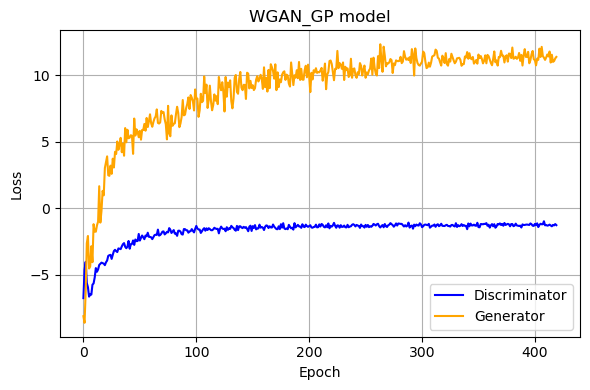

In [ ]:
should_stop = False
# --- 모델, 옵티마이저 초기화 ---

# ---파라미터 ---
best_fid = float("inf")  # early stopping을 위한 fid 스코어
patience = 5  # patience값
counter = 0
model_name = "WGAN_GP_linear"
n_critic = 5  # Critic을 5번 학습시킬 때 Generator를 1번 학습
lambda_gp = 10  # Gradient Penalty의 가중치

FID_TOTAL2 = []
D_losses_2 = []
G_losses_2 = []
# --- 학습 루프 ---
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    loop = tqdm(train_loader)
    generator.train()  # 에폭 시작 시 train 모드 명시
    critic.train()
    for i, (imgs, labels) in enumerate(loop):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        z = torch.randn(imgs.shape[0], latent_dim).to(device)
        fake_imgs = generator(z, labels)

        # ---------------------
        #  Discriminator 학습
        # ---------------------
        optimizer_D.zero_grad()

        real_validity = critic(real_imgs, labels)
        fake_validity = critic(fake_imgs.detach(), labels)

        # Gradient Penalty 계산
        gradient_penalty = compute_gradient_penalty(
            critic, real_imgs.data, fake_imgs.data, labels.data
        )

        # Critic 최종 Loss
        d_loss = (
            -torch.mean(real_validity)
            + torch.mean(fake_validity)
            + lambda_gp * gradient_penalty
        )

        d_loss.backward()
        optimizer_D.step()
        epoch_d_loss += d_loss.item()

        # ---------------------
        #  Generator 학습 (n_critic 스텝마다 1번)
        # ---------------------
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # 새로운 가짜 이미지 생성
            gen_imgs = generator(z, labels)
            # Generator가 얼마나 Critic을 잘 속였는지 평가
            fake_validity = critic(gen_imgs, labels)

            # Generator Loss
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
            epoch_g_loss += g_loss.item()

    D_losses_2.append(d_loss.item())
    G_losses_2.append(g_loss.item())
    # 스케줄러: cosine Anealing
    scheduler_G.step()
    scheduler_D.step()
    # <--- 변경점 4: '평균' 손실 계산 및 기록
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / (
        len(train_loader) / n_critic
    )  # g_loss가 업데이트된 횟수로 나눠줌

    # ----------------------------------------------------
    #  Epoch 종료 후 평가, 저장, 시각화
    # ----------------------------------------------------
    critic.eval()
    generator.eval()
    with torch.no_grad():
        # 5 에폭마다 샘플 이미지 저장
        if (epoch + 1) % 5 == 0:
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}"
            )

            z = torch.randn(num_classes * 10, latent_dim).to(device)
            labels_to_sample = torch.LongTensor(
                np.array([num for _ in range(10) for num in range(num_classes)])
            ).to(device)
            sampled_imgs = generator(z, labels_to_sample)
            save_image(
                sampled_imgs.data,
                f"images/{model_name}_{epoch+1}.png",
                nrow=num_classes,
                normalize=True,
            )
            print(f"Saved sample images to images/{model_name}_{epoch+1}.png")

        # 10 에폭마다 FID 평가 및 시각화
        if (epoch + 1) % 10 == 0:
            # FID 평가 및 Early Stopping
            fid_score = calculate_fid(generator, val_loader, device)
            print(f"--> Current FID: {fid_score:.4f} | Best FID: {best_fid:.4f}")
            FID_TOTAL2.append(fid_score)

            if fid_score < best_fid:
                best_fid = fid_score
                counter = 0
                torch.save(generator.state_dict(), "best_generator.pth")
                print("✨ New best model saved!")
            else:
                counter += 1
                print(f"Patience counter: {counter}/{patience}")
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    should_stop = True  # <--- 변경된 점: 플래그 설정

            # # 이미지 시각화
            # n_row, n_col = 3, num_classes
            # noise = torch.randn(n_row * n_col, latent_dim, device=device)
            # labels_sample = torch.arange(0, n_col, device=device).repeat(n_row)
            # gen_imgs = generator(noise, labels_sample).detach().cpu()

            # fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
            # for i in range(n_row):
            #     for j in range(n_col):
            #         idx = i * n_col + j
            #         axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap="gray")
            #         axs[i, j].axis("off")
            #         if i == 0:
            #             axs[i, j].set_title(idx_to_class[j], fontsize=10)
            # plt.tight_layout()
            # plt.show()

    # <--- 변경된 점: 루프 마지막에서 탈출 여부 확인
    if should_stop:
        break

# 학습 시각화
plt.figure(figsize=(6, 4))
plt.plot(D_losses_2, label="Discriminator", color="blue")
plt.plot(G_losses_2, label="Generator", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{model_name} model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# test set에서 최종 평가
calculate_fid(generator, test_loader, device)

Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


⚪ FID Score: 59.18661502684148


np.float64(59.18661502684148)

In [14]:
# 메모리 정리 루틴
del generator
del critic
del optimizer_G
del optimizer_D

gc.collect()
torch.cuda.empty_cache()
print(f"✅ Memory cleared for next run.")
print("=" * 40 + "\n")

✅ Memory cleared for next run.



In [15]:
# 모델 초기화
generator = Generator().to(device)
critic = Discriminator_Critic_Conv().to(device)

# WGAN에서 추천하는 Adam 세팅
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizer_D = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=NUM_EPOCHS, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=NUM_EPOCHS, eta_min=1e-6)

Epoch [1/500]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch [5/500] D_loss: -6.1567  G_loss: 19.8172
Saved sample images to images/WGAN_GP_conv_5.png


Epoch [10/500] D_loss: -4.5800  G_loss: 31.9931
Saved sample images to images/WGAN_GP_conv_10.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


⚪ FID Score: 148.19122175446554
--> Current FID: 148.1912 | Best FID: inf
✨ New best model saved!


Epoch [15/500] D_loss: -3.7593  G_loss: 40.2183
Saved sample images to images/WGAN_GP_conv_15.png


Epoch [20/500] D_loss: -3.1468  G_loss: 46.8344
Saved sample images to images/WGAN_GP_conv_20.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 97.01391958515921
--> Current FID: 97.0139 | Best FID: 148.1912
✨ New best model saved!


Epoch [25/500] D_loss: -2.6374  G_loss: 52.7816
Saved sample images to images/WGAN_GP_conv_25.png


Epoch [30/500] D_loss: -2.3409  G_loss: 57.3542
Saved sample images to images/WGAN_GP_conv_30.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 72.49797571833943
--> Current FID: 72.4980 | Best FID: 97.0139
✨ New best model saved!


Epoch [35/500] D_loss: -2.1914  G_loss: 60.6425
Saved sample images to images/WGAN_GP_conv_35.png


Epoch [40/500] D_loss: -2.0591  G_loss: 63.9799
Saved sample images to images/WGAN_GP_conv_40.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 61.134379321408375
--> Current FID: 61.1344 | Best FID: 72.4980
✨ New best model saved!


Epoch [45/500] D_loss: -1.9659  G_loss: 66.6784
Saved sample images to images/WGAN_GP_conv_45.png


Epoch [50/500] D_loss: -1.8886  G_loss: 69.2121
Saved sample images to images/WGAN_GP_conv_50.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.32s/it]


⚪ FID Score: 53.90742325035666
--> Current FID: 53.9074 | Best FID: 61.1344
✨ New best model saved!


Epoch [55/500] D_loss: -1.8387  G_loss: 70.9527
Saved sample images to images/WGAN_GP_conv_55.png


Epoch [60/500] D_loss: -1.7923  G_loss: 73.0417
Saved sample images to images/WGAN_GP_conv_60.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 49.04952820840782
--> Current FID: 49.0495 | Best FID: 53.9074
✨ New best model saved!


Epoch [65/500] D_loss: -1.7563  G_loss: 74.5504
Saved sample images to images/WGAN_GP_conv_65.png


Epoch [70/500] D_loss: -1.7180  G_loss: 75.6665
Saved sample images to images/WGAN_GP_conv_70.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.35s/it]


⚪ FID Score: 45.055978301853656
--> Current FID: 45.0560 | Best FID: 49.0495
✨ New best model saved!


Epoch [75/500] D_loss: -1.6864  G_loss: 76.4849
Saved sample images to images/WGAN_GP_conv_75.png


Epoch [80/500] D_loss: -1.6510  G_loss: 76.8771
Saved sample images to images/WGAN_GP_conv_80.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 42.473685874907915
--> Current FID: 42.4737 | Best FID: 45.0560
✨ New best model saved!


Epoch [85/500] D_loss: -1.6188  G_loss: 77.2265
Saved sample images to images/WGAN_GP_conv_85.png


Epoch [90/500] D_loss: -1.5986  G_loss: 77.4478
Saved sample images to images/WGAN_GP_conv_90.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 42.28061265402084
--> Current FID: 42.2806 | Best FID: 42.4737
✨ New best model saved!


Epoch [95/500] D_loss: -1.5662  G_loss: 77.1237
Saved sample images to images/WGAN_GP_conv_95.png


Epoch [100/500] D_loss: -1.5516  G_loss: 77.4303
Saved sample images to images/WGAN_GP_conv_100.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 40.201532657712676
--> Current FID: 40.2015 | Best FID: 42.2806
✨ New best model saved!


Epoch [105/500] D_loss: -1.5275  G_loss: 77.3170
Saved sample images to images/WGAN_GP_conv_105.png


Epoch [110/500] D_loss: -1.4977  G_loss: 77.2399
Saved sample images to images/WGAN_GP_conv_110.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 38.85002849084918
--> Current FID: 38.8500 | Best FID: 40.2015
✨ New best model saved!


Epoch [115/500] D_loss: -1.4859  G_loss: 77.3397
Saved sample images to images/WGAN_GP_conv_115.png


Epoch [120/500] D_loss: -1.4677  G_loss: 77.6022
Saved sample images to images/WGAN_GP_conv_120.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 37.49778148099335
--> Current FID: 37.4978 | Best FID: 38.8500
✨ New best model saved!


Epoch [125/500] D_loss: -1.4494  G_loss: 78.1613
Saved sample images to images/WGAN_GP_conv_125.png


Epoch [130/500] D_loss: -1.4304  G_loss: 78.3776
Saved sample images to images/WGAN_GP_conv_130.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 35.63303182214389
--> Current FID: 35.6330 | Best FID: 37.4978
✨ New best model saved!


Epoch [135/500] D_loss: -1.4103  G_loss: 78.8909
Saved sample images to images/WGAN_GP_conv_135.png


Epoch [140/500] D_loss: -1.3863  G_loss: 79.4268
Saved sample images to images/WGAN_GP_conv_140.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 35.305705629952456
--> Current FID: 35.3057 | Best FID: 35.6330
✨ New best model saved!


Epoch [145/500] D_loss: -1.3594  G_loss: 79.6145
Saved sample images to images/WGAN_GP_conv_145.png


Epoch [150/500] D_loss: -1.3343  G_loss: 79.9877
Saved sample images to images/WGAN_GP_conv_150.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 34.891225520297326
--> Current FID: 34.8912 | Best FID: 35.3057
✨ New best model saved!


Epoch [155/500] D_loss: -1.2948  G_loss: 80.0155
Saved sample images to images/WGAN_GP_conv_155.png


Epoch [160/500] D_loss: -1.2722  G_loss: 80.8975
Saved sample images to images/WGAN_GP_conv_160.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:42<00:00,  8.13s/it]


⚪ FID Score: 33.892175136314165
--> Current FID: 33.8922 | Best FID: 34.8912
✨ New best model saved!


Epoch [165/500] D_loss: -1.2530  G_loss: 81.4972
Saved sample images to images/WGAN_GP_conv_165.png


Epoch [170/500] D_loss: -1.2239  G_loss: 82.0432
Saved sample images to images/WGAN_GP_conv_170.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:42<00:00,  8.14s/it]


⚪ FID Score: 32.0958391031013
--> Current FID: 32.0958 | Best FID: 33.8922
✨ New best model saved!


Epoch [175/500] D_loss: -1.2052  G_loss: 82.3571
Saved sample images to images/WGAN_GP_conv_175.png


Epoch [180/500] D_loss: -1.1902  G_loss: 83.0027
Saved sample images to images/WGAN_GP_conv_180.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:42<00:00,  8.13s/it]


⚪ FID Score: 30.97739010544626
--> Current FID: 30.9774 | Best FID: 32.0958
✨ New best model saved!


Epoch [185/500] D_loss: -1.1832  G_loss: 83.3894
Saved sample images to images/WGAN_GP_conv_185.png


Epoch [190/500] D_loss: -1.1738  G_loss: 83.7563
Saved sample images to images/WGAN_GP_conv_190.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 29.73853002166146
--> Current FID: 29.7385 | Best FID: 30.9774
✨ New best model saved!


Epoch [195/500] D_loss: -1.1585  G_loss: 84.3051
Saved sample images to images/WGAN_GP_conv_195.png


Epoch [200/500] D_loss: -1.1464  G_loss: 84.6207
Saved sample images to images/WGAN_GP_conv_200.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 28.951772463340944
--> Current FID: 28.9518 | Best FID: 29.7385
✨ New best model saved!


Epoch [205/500] D_loss: -1.1424  G_loss: 84.9333
Saved sample images to images/WGAN_GP_conv_205.png


Epoch [210/500] D_loss: -1.1284  G_loss: 85.3897
Saved sample images to images/WGAN_GP_conv_210.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 28.81574876561058
--> Current FID: 28.8157 | Best FID: 28.9518
✨ New best model saved!


Epoch [215/500] D_loss: -1.1178  G_loss: 85.9372
Saved sample images to images/WGAN_GP_conv_215.png


Epoch [220/500] D_loss: -1.1168  G_loss: 86.2750
Saved sample images to images/WGAN_GP_conv_220.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 28.221848745478894
--> Current FID: 28.2218 | Best FID: 28.8157
✨ New best model saved!


Epoch [225/500] D_loss: -1.1113  G_loss: 86.7438
Saved sample images to images/WGAN_GP_conv_225.png


Epoch [230/500] D_loss: -1.0980  G_loss: 87.2840
Saved sample images to images/WGAN_GP_conv_230.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 27.58427782682395
--> Current FID: 27.5843 | Best FID: 28.2218
✨ New best model saved!


Epoch [235/500] D_loss: -1.0907  G_loss: 87.7917
Saved sample images to images/WGAN_GP_conv_235.png


Epoch [240/500] D_loss: -1.0865  G_loss: 88.2536
Saved sample images to images/WGAN_GP_conv_240.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 27.808972343202527
--> Current FID: 27.8090 | Best FID: 27.5843
Patience counter: 1/5


Epoch [245/500] D_loss: -1.0831  G_loss: 88.6473
Saved sample images to images/WGAN_GP_conv_245.png


Epoch [250/500] D_loss: -1.0767  G_loss: 89.0528
Saved sample images to images/WGAN_GP_conv_250.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 26.846986871878755
--> Current FID: 26.8470 | Best FID: 27.5843
✨ New best model saved!


Epoch [255/500] D_loss: -1.0728  G_loss: 89.4838
Saved sample images to images/WGAN_GP_conv_255.png


Epoch [260/500] D_loss: -1.0618  G_loss: 89.9140
Saved sample images to images/WGAN_GP_conv_260.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 26.644661704295743
--> Current FID: 26.6447 | Best FID: 26.8470
✨ New best model saved!


Epoch [265/500] D_loss: -1.0656  G_loss: 90.1479
Saved sample images to images/WGAN_GP_conv_265.png


Epoch [270/500] D_loss: -1.0575  G_loss: 90.5751
Saved sample images to images/WGAN_GP_conv_270.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 25.826739410221364
--> Current FID: 25.8267 | Best FID: 26.6447
✨ New best model saved!


Epoch [275/500] D_loss: -1.0512  G_loss: 90.9141
Saved sample images to images/WGAN_GP_conv_275.png


Epoch [280/500] D_loss: -1.0509  G_loss: 91.0752
Saved sample images to images/WGAN_GP_conv_280.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 25.61387591223979
--> Current FID: 25.6139 | Best FID: 25.8267
✨ New best model saved!


Epoch [285/500] D_loss: -1.0429  G_loss: 91.4275
Saved sample images to images/WGAN_GP_conv_285.png


Epoch [290/500] D_loss: -1.0469  G_loss: 91.6180
Saved sample images to images/WGAN_GP_conv_290.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 26.02608640397949
--> Current FID: 26.0261 | Best FID: 25.6139
Patience counter: 1/5


Epoch [295/500] D_loss: -1.0393  G_loss: 91.9820
Saved sample images to images/WGAN_GP_conv_295.png


Epoch [300/500] D_loss: -1.0352  G_loss: 92.3073
Saved sample images to images/WGAN_GP_conv_300.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 26.28576827706422
--> Current FID: 26.2858 | Best FID: 25.6139
Patience counter: 2/5


Epoch [305/500] D_loss: -1.0327  G_loss: 92.4264
Saved sample images to images/WGAN_GP_conv_305.png


Epoch [310/500] D_loss: -1.0329  G_loss: 92.7034
Saved sample images to images/WGAN_GP_conv_310.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 25.426901851630873
--> Current FID: 25.4269 | Best FID: 25.6139
✨ New best model saved!


Epoch [315/500] D_loss: -1.0286  G_loss: 92.8382
Saved sample images to images/WGAN_GP_conv_315.png


Epoch [320/500] D_loss: -1.0307  G_loss: 93.0898
Saved sample images to images/WGAN_GP_conv_320.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:45<00:00,  8.30s/it]


⚪ FID Score: 25.379058918954684
--> Current FID: 25.3791 | Best FID: 25.4269
✨ New best model saved!


Epoch [325/500] D_loss: -1.0317  G_loss: 93.2874
Saved sample images to images/WGAN_GP_conv_325.png


Epoch [330/500] D_loss: -1.0254  G_loss: 93.6004
Saved sample images to images/WGAN_GP_conv_330.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.34s/it]


⚪ FID Score: 25.277878329472287
--> Current FID: 25.2779 | Best FID: 25.3791
✨ New best model saved!


Epoch [335/500] D_loss: -1.0275  G_loss: 93.9294
Saved sample images to images/WGAN_GP_conv_335.png


Epoch [340/500] D_loss: -1.0197  G_loss: 93.9554
Saved sample images to images/WGAN_GP_conv_340.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:45<00:00,  8.30s/it]


⚪ FID Score: 25.26853582088961
--> Current FID: 25.2685 | Best FID: 25.2779
✨ New best model saved!


Epoch [345/500] D_loss: -1.0216  G_loss: 94.1790
Saved sample images to images/WGAN_GP_conv_345.png


Epoch [350/500] D_loss: -1.0234  G_loss: 94.4858
Saved sample images to images/WGAN_GP_conv_350.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.32s/it]


⚪ FID Score: 25.079088246221772
--> Current FID: 25.0791 | Best FID: 25.2685
✨ New best model saved!


Epoch [355/500] D_loss: -1.0202  G_loss: 94.8149
Saved sample images to images/WGAN_GP_conv_355.png


Epoch [360/500] D_loss: -1.0206  G_loss: 94.8683
Saved sample images to images/WGAN_GP_conv_360.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 24.42403385346438
--> Current FID: 24.4240 | Best FID: 25.0791
✨ New best model saved!


Epoch [365/500] D_loss: -1.0179  G_loss: 95.0252
Saved sample images to images/WGAN_GP_conv_365.png


Epoch [370/500] D_loss: -1.0173  G_loss: 95.0671
Saved sample images to images/WGAN_GP_conv_370.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.30s/it]


⚪ FID Score: 24.720559325729937
--> Current FID: 24.7206 | Best FID: 24.4240
Patience counter: 1/5


Epoch [375/500] D_loss: -1.0175  G_loss: 95.1751
Saved sample images to images/WGAN_GP_conv_375.png


Epoch [380/500] D_loss: -1.0204  G_loss: 95.3476
Saved sample images to images/WGAN_GP_conv_380.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.32s/it]


⚪ FID Score: 24.449196124993534
--> Current FID: 24.4492 | Best FID: 24.4240
Patience counter: 2/5


Epoch [385/500] D_loss: -1.0208  G_loss: 95.3222
Saved sample images to images/WGAN_GP_conv_385.png


Epoch [390/500] D_loss: -1.0179  G_loss: 95.5309
Saved sample images to images/WGAN_GP_conv_390.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 24.952217846138012
--> Current FID: 24.9522 | Best FID: 24.4240
Patience counter: 3/5


Epoch [395/500] D_loss: -1.0197  G_loss: 95.6677
Saved sample images to images/WGAN_GP_conv_395.png


Epoch [400/500] D_loss: -1.0197  G_loss: 95.7142
Saved sample images to images/WGAN_GP_conv_400.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.32s/it]


⚪ FID Score: 24.889389037703836
--> Current FID: 24.8894 | Best FID: 24.4240
Patience counter: 4/5


Epoch [405/500] D_loss: -1.0170  G_loss: 95.8059
Saved sample images to images/WGAN_GP_conv_405.png


Epoch [410/500] D_loss: -1.0198  G_loss: 95.8834
Saved sample images to images/WGAN_GP_conv_410.png
Calculating FID Score...
Generating fake images for FID calculation...


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


⚪ FID Score: 24.644980723600156
--> Current FID: 24.6450 | Best FID: 24.4240
Patience counter: 5/5
Early stopping triggered at epoch 410


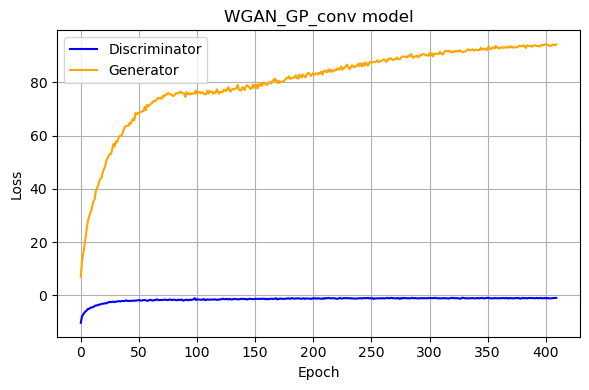

In [16]:
should_stop = False
# --- 모델, 옵티마이저 초기화 ---

# ---파라미터 ---
best_fid = float("inf")  # early stopping을 위한 fid 스코어
patience = 5  # patience값
counter = 0
model_name = "WGAN_GP_conv"
n_critic = 5  # Critic을 5번 학습시킬 때 Generator를 1번 학습
lambda_gp = 10  # Gradient Penalty의 가중치

FID_TOTAL2 = []
D_losses_2 = []
G_losses_2 = []
# --- 학습 루프 ---
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]", leave=False)
    generator.train()  # 에폭 시작 시 train 모드 명시
    critic.train()
    for i, (imgs, labels) in enumerate(loop):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        z = torch.randn(imgs.shape[0], latent_dim).to(device)
        fake_imgs = generator(z, labels)

        # ---------------------
        #  Discriminator 학습
        # ---------------------
        optimizer_D.zero_grad()

        real_validity = critic(real_imgs, labels)
        fake_validity = critic(fake_imgs.detach(), labels)

        # Gradient Penalty 계산
        gradient_penalty = compute_gradient_penalty(
            critic, real_imgs.data, fake_imgs.data, labels.data
        )

        # Critic 최종 Loss
        d_loss = (
            -torch.mean(real_validity)
            + torch.mean(fake_validity)
            + lambda_gp * gradient_penalty
        )

        d_loss.backward()
        optimizer_D.step()
        epoch_d_loss += d_loss.item()

        # ---------------------
        #  Generator 학습 (n_critic 스텝마다 1번)
        # ---------------------
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # 새로운 가짜 이미지 생성
            gen_imgs = generator(z, labels)
            # Generator가 얼마나 Critic을 잘 속였는지 평가
            fake_validity = critic(gen_imgs, labels)

            # Generator Loss
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
            epoch_g_loss += g_loss.item()

    D_losses_2.append(d_loss.item())
    G_losses_2.append(g_loss.item())
    # 스케줄러: cosine Anealing
    scheduler_G.step()
    scheduler_D.step()
    # <--- 변경점 4: '평균' 손실 계산 및 기록
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / (
        len(train_loader) / n_critic
    )  # g_loss가 업데이트된 횟수로 나눠줌

    # ----------------------------------------------------
    #  Epoch 종료 후 평가, 저장, 시각화
    # ----------------------------------------------------
    critic.eval()
    generator.eval()
    with torch.no_grad():
        # 5 에폭마다 샘플 이미지 저장
        if (epoch + 1) % 5 == 0:
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}"
            )

            z = torch.randn(num_classes * 10, latent_dim).to(device)
            labels_to_sample = torch.LongTensor(
                np.array([num for _ in range(10) for num in range(num_classes)])
            ).to(device)
            sampled_imgs = generator(z, labels_to_sample)
            save_image(
                sampled_imgs.data,
                f"images/{model_name}_{epoch+1}.png",
                nrow=num_classes,
                normalize=True,
            )
            print(f"Saved sample images to images/{model_name}_{epoch+1}.png")

        # 10 에폭마다 FID 평가 및 시각화
        if (epoch + 1) % 10 == 0:
            # FID 평가 및 Early Stopping
            fid_score = calculate_fid(generator, val_loader, device)
            print(f"--> Current FID: {fid_score:.4f} | Best FID: {best_fid:.4f}")
            FID_TOTAL2.append(fid_score)

            if fid_score < best_fid:
                best_fid = fid_score
                counter = 0
                torch.save(generator.state_dict(), "best_generator.pth")
                print("✨ New best model saved!")
            else:
                counter += 1
                print(f"Patience counter: {counter}/{patience}")
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    should_stop = True  # <--- 변경된 점: 플래그 설정

            # # 이미지 시각화
            # n_row, n_col = 3, num_classes
            # noise = torch.randn(n_row * n_col, latent_dim, device=device)
            # labels_sample = torch.arange(0, n_col, device=device).repeat(n_row)
            # gen_imgs = generator(noise, labels_sample).detach().cpu()

            # fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
            # for i in range(n_row):
            #     for j in range(n_col):
            #         idx = i * n_col + j
            #         axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap="gray")
            #         axs[i, j].axis("off")
            #         if i == 0:
            #             axs[i, j].set_title(idx_to_class[j], fontsize=10)
            # plt.tight_layout()
            # plt.show()

    # <--- 변경된 점: 루프 마지막에서 탈출 여부 확인
    if should_stop:
        break

# 학습 시각화
plt.figure(figsize=(6, 4))
plt.plot(D_losses_2, label="Discriminator", color="blue")
plt.plot(G_losses_2, label="Generator", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{model_name} model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Results & Disscussion

(302, 302, 3)

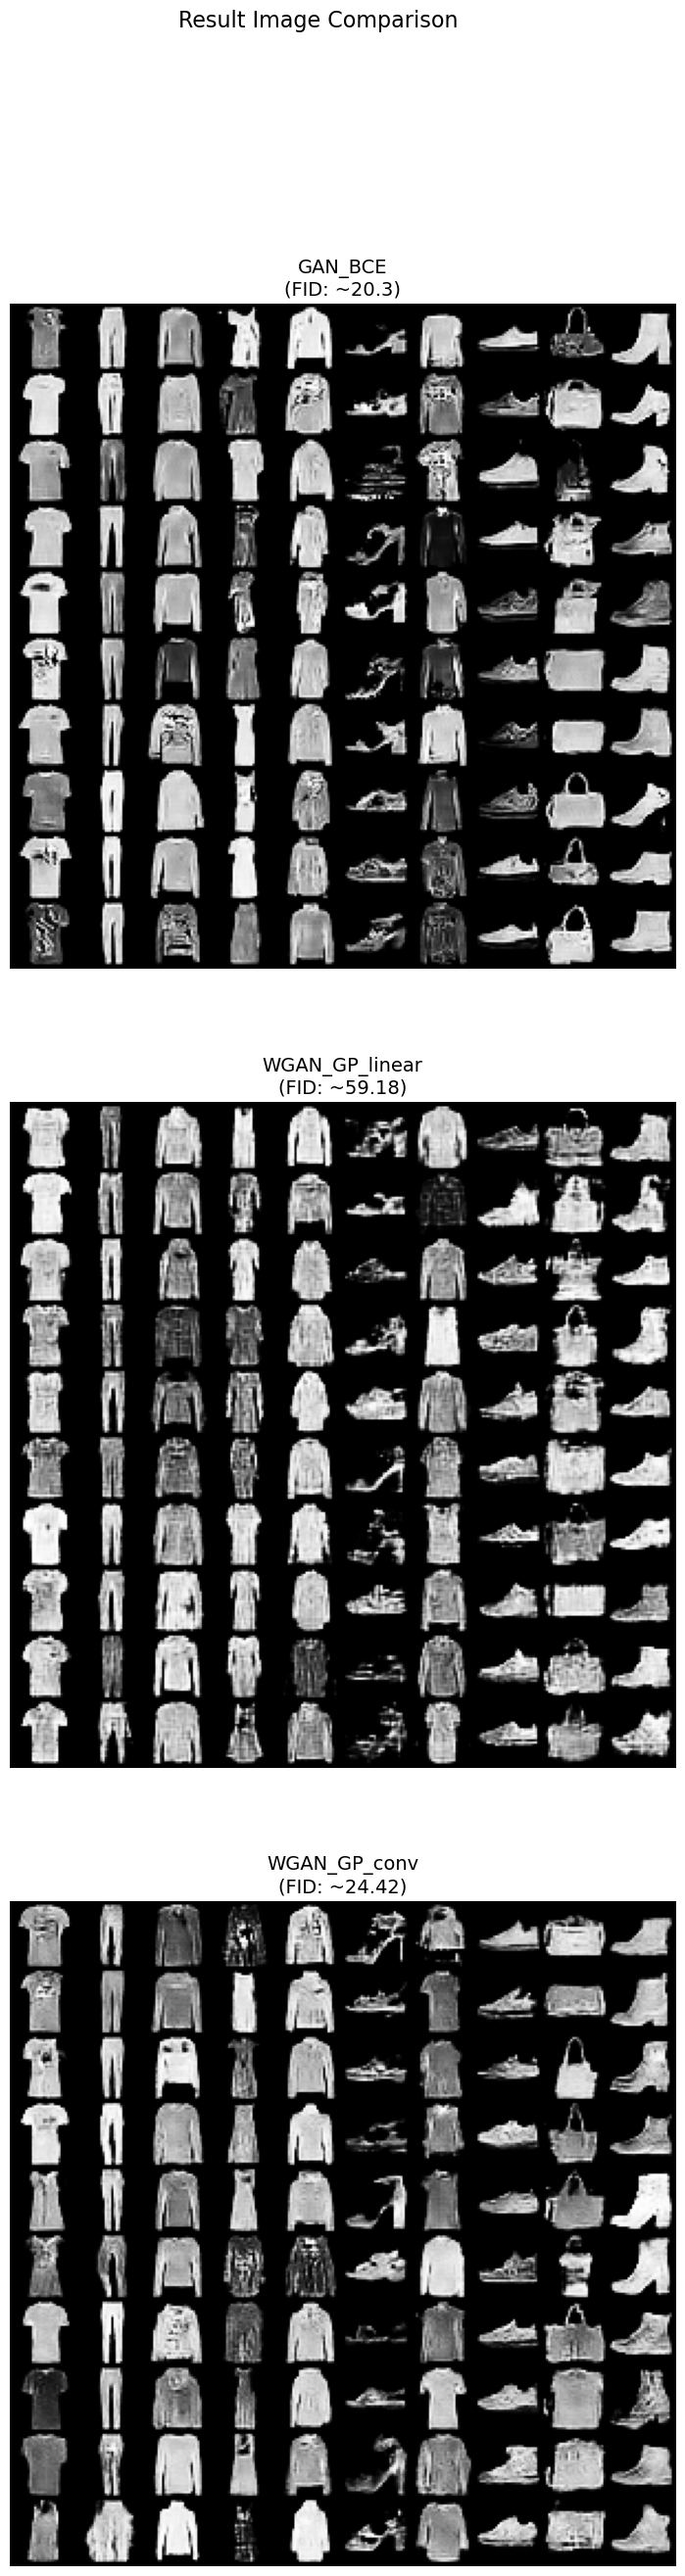

In [35]:
# 1행 3열의 subplot 생성
fig, axes = plt.subplots(3, 1, figsize=(20, 30))
fig.suptitle(f"Result Image Comparison", fontsize=16)
ax = axes[0]
img = cv2.imread("images/GAN_BCE_180.png")
ax.set_title(f"GAN_BCE\n(FID: ~20.3)", fontsize=14)
ax.axis(False)
ax.imshow(img)


ax = axes[1]
img = cv2.imread("images/WGAN_GP_linear_450.png")
ax.imshow(img)
ax.set_title(f"WGAN_GP_linear\n(FID: ~59.18)", fontsize=14)
ax.axis(False)
img.shape


ax = axes[2]
img = cv2.imread("images/WGAN_GP_conv_435.png")
ax.imshow(img)
ax.set_title(f"WGAN_GP_conv\n(FID: ~24.42)", fontsize=14)
ax.axis(False)
img.shape

결과를 보면 FID 결과가 뛰어난 GAN_BCE가 가장 선명한 그림체를 보여주고 있다. 

또한 비슷한 FID인 WGAN_GP_conv 모델도 비교적 괜찮은 성능은 보였지만 noisy한 질감이 많이 관찰이 되었다. 하지만 외형적인 부분에서는 크게 하자가 없었다. low freaquency 정보는 잘 생성했지만 high frequency 정보가 불안정한 모습이었다.

그리고 FID가 가장 안좋은 WGAN_GP_linear 모델은 frequency 관점에서 모두 안좋은 성능을 보여줬다. FC layer 기반의 Generator는 공간정보를 잃기 때문에 conv 보다 low, high freqeuncy에서 모두 안좋은 모습이었다.

## 7. Conclusion

본 과제는 FashionMNIST 데이터셋을 활용하여 세 가지 다른 방식의 조건부 생성형 적대 신경망(cGAN) 모델을 학습하고, 그 성능을 정량적 및 정성적으로 비교 분석하는 것을 목표로 진행되었다. 실험에 사용된 모델은 BCE 기반의 표준 GAN, MLP(선형) 판별자를 사용한 WGAN-GP, 그리고 합성곱(Convolutional) 판별자를 사용한 WGAN-GP이다.

BCE-GAN (Binary Cross-Entropy GAN)은 GAN의 가장 기본적인 형태로, 생성자와 판별자가 서로를 속이고 간파하려는 제로섬(zero-sum) 게임을 진행한다. 이진 교차 엔트로피(BCE) 손실 함수를 사용하여 학습하며, 이론적으로 불안정하여 학습이 어렵고 '모드 붕괴(mode collapse)' 현상이 발생하기 쉬운 것으로 알려져 있다. 반면 WGAN-GP (Wasserstein GAN with Gradient Penalty): 표준 GAN의 불안정성을 해결하기 위해 제안된 고급 기법이다. 판별자를 확률을 예측하는 분류기가 아닌, 실제와 가짜 데이터 분포 간의 **바서슈타인 거리(Wasserstein Distance)**를 측정하는 비평가(Critic)로 기능하게 한다. 여기에 **그래디언트 페널티(Gradient Penalty)**를 추가하여 학습 과정을 매우 안정적으로 만드는 것이 핵심이다.

실험의 구성은 BCE loss를 사용하는 GAN과 스코어 기반의 WGAN-GP를 비교하는 것이었다. 또한 세부적으로 WGAN-GP는 linear기반과 학습이 가능한 convolution layer 기반의 구조로 총 3가지 형태이다.

결과적으로 FID를 따져보면
1) BCE-GAN:     	20.31
2) WGAN-GP_Linear:	59.18
3) WGAN-GP_conv:	24.42

분석 결과, BCE-GAN이 FID 스코어 20.31로 가장 우수한 성능을 보였다. 이는 FashionMNIST와 같이 비교적 단순한 데이터셋에서는 하이퍼파라미터가 잘 조율된 표준 GAN도 매우 높은 품질의 결과를 낼 수 있음을 알 수 있다.

WGAN-GP (Convolutional Critic) 역시 FID 24.42라는 매우 경쟁력 있는 점수를 기록하며, 안정적인 학습과 더불어 우수한 이미지 생성 능력을 입증했다. 반면, WGAN-GP (Linear Critic) 모델은 FID 59.18로 성능이 가장 저조했다. 이는 아무리 뛰어난 손실 함수(WGAN-GP)를 사용하더라도, 이미지의 공간적 특징을 학습할 수 없는 부적절한 판별자 구조(MLP)를 사용하면 학습이 실패한다는 것을 명확히 보여주는 결과이다.